<h1><center>Project Statement</center></h1>

<h1><center> Personalized Insurance Product Recommendations: A Data-Driven Approach </center> </h1>

<h2>Objectives</h2>

<ul>
<li> Leverage customer data (demographics, behavioral, attitudinal) to understand customer needs and preferences. </li>
<li>Develop a recommendation system that suggests relevant insurance products.</li>
<li>Optimize product development and pricing by analyzing the popularity of diverse insurance products.</li>
</ul>


<h2>Data Cookbook</h2>

<p>The dataset used in this project originates from an automobile insurance company. The customer or insurance agent enters the data on the company website while registering to buy automobile insurance. Personal or Identifying Information is removed from the dataset. It contains valuable information about customer demographics, vehicle characteristics, and the specific insurance policies they hold. This comprehensive data provides a rich landscape for exploring and predicting the insurance policy preferences of prospective customers.</p>


<h3>Column and Data Description</h3>

<ol>
<li><p><u>id</u> - The unique customer id. </p></li>
<li><p><u>Gender</u> - The gender of the customer. Either Male or Female.</p></li>
<li><p><u>Age</u> - The age of the customer</p></li>
<li><p><u>Region_Code</u> - The region code is the Census Bureau of the United States of America–designated regions and divisions  of the customer's residential address. It has four possible values:-
<ul>
    <li>North-East abbreviated as NE</li>
    <li>Mid-West abbreviated as MW</li>
    <li>South abbreviated as S</li>
    <li>West abbreviated as W</li>
</ul>
</p></li>
<li><p><u>Location_Type</u> - States whether the customer's residential address is in an urban, suburban, or rural locality.</p></li>
<li><p><u>Education</u> - The Education qualification of the customer. It has five possible values:-
<ul>
    <li>High School or Below</li>
    <li>College</li>
    <li>Bachelors</li>
    <li>Masters</li>
    <li>Doctor</li>
</ul>
</p></li>
<li><p><u>Annual_Income</u> - The annual income of customer in dollars.</p></li>
<li><p><u>Vehicle_Type</u> - The type of vehicle the customer has insured. Vehicle Type has been categorized as follow:-</p></li>
<ul>
    <li>Normal Car</li>
    <li>SUV</li>
    <li>Luxury Car</li>
    <li>Luxury SUV</li>
</ul>
<li><p><u>Previously_Insured</u> - 1 if the vehicle has been insured previously with our company or else 0.</p></li>
<li><p><u>Vehicle_Age</u> - States whether the vehicle is less than 10 years old, 10-20 years old, or greater than 20 years old.</p></li>
<li><p><u>Vehicle_Damage</u> - Yes if the vehicle has suffered damage in the past or else No.</p></li>
<li><p><u>Policy</u> - The Automobile Insurance Policy that the customer holds. The company sells seven different kinds of policies:-</p></li>
    <ul>
        <li>Platinium Tier I</li>
        <li>Platinium Tier II</li>
        <li>Gold Tier I</li>
        <li>Gold Tier II</li>
        <li>Silver Tier I</li>
        <li>Silver Tier II</li>
        <li>Basic</li>
    </ul>
</ol>

<h2>Library Declarations</h2>

In [227]:
from pandas import read_csv, DataFrame, concat, crosstab, IndexSlice, option_context, set_option, Categorical
import numpy as np
from functools import partial
from scipy.stats import chi2_contingency,fisher_exact
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from IPython.core.display import HTML
from io import StringIO
from os.path import exists
from json import load, dump
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, KBinsDiscretizer
from sklearn.naive_bayes import GaussianNB, CategoricalNB
import joblib
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from warnings import filterwarnings
filterwarnings('ignore')

<h2>Helper Function Declarations</h2>

<h4>count_iqr_outliers</h4>

<p> This function takes a DataFrame and a column name and returns the number of outliers 
  based on the Interquartile Range (IQR) method.</p>

<p>&emsp;  Args:</p>
      <p>&emsp;&emsp; column: A column in dataframe</p>

<p>&emsp;  Returns:</p>
      <p>&emsp; &emsp; int: The number of outliers found in the specified column.</p>

In [2]:
def count_iqr_outliers(column):
    # Calculate IQR
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    num_outliers = sum([(item < lower_bound) | (item > upper_bound) for item in column])

    return(num_outliers)
    

<h4>calculate_stack_percentages </h4>

<p>This function calculates the percentages of values of column 2 occurring given column1 has a particular value. It does for all possible values of column1</p> 

<p>&emsp;  Args: </p>
<p>&emsp;&emsp;      df: A dataframe </p>
<p>&emsp;&emsp;      column1: A column in dataframe</p>
<p>&emsp;&emsp;       column2: A column in dataframe</p>
<p>&emsp;&emsp;       order1: A list specifying the order of column1</p>
<p>&emsp;&emsp;       order2: A list specifying the order of column2</p>

<p>&emsp;   Returns:</p>
<p>&emsp;&emsp;       2d List: A 2d list of percentages for all combinations of values for column1 and column 2. </p>

In [3]:
def calculate_stack_percentages(df,column1,column2,order1=[],order2=[]):
    order1 = order1 if order1 else df.sort_values(column1)[column1].unique()
    order2 = order2 if order2 else df.sort_values(column2)[column2].unique()
    # Calculate the percentages and save it a 2D list
    percents = [[(np.round(len(df[(df[column1] == i) & (df[column2]==j)])/len(df[df[column1] == i])*100,decimals=1),
                  np.round(len(df[(df[column1] == i) & (df[column2]==j)])/len(df)*100,decimals=1))
                 for i in order1]
                for j in order2]
    return(percents)  

<h4>first_quantile </h4>

<p>This function calculates the first quantile of a column</p>

<p>&emsp;  Args:</p>
<p>&emsp;&emsp;       column: A column in dataframe</p>

  <p>&emsp;Returns:</p>
      <p>&emsp;&emsp; float: First quantile of the column</p>

In [4]:
def first_quantile(column):
    return(column.quantile(0.25))

<h4>third_quantile </h4>

<p>This function calculates the third quantile of a column</p>

<p>&emsp;  Args:</p>
<p>&emsp;&emsp;       column: A column in dataframe</p>

  <p>&emsp;Returns:</p>
      <p>&emsp;&emsp; float: third quantile of the column</p>

In [5]:
def third_quantile(column):
    return(column.quantile(0.75))

<h4>IQR</h4>

<p>This function calculates the Inter-quantile range of a column</p

<p>&emsp;  Args:</p>
<p>&emsp;&emsp;       column: A column in dataframe</p>

<p>&emsp; Returns: </p> 
    <p>&emsp;&emsp;  float: Inter-quantile range of the column</p>

In [6]:
def IQR(column):
    return(third_quantile(column)-first_quantile(column))

<h4>pretty_display</h4>

<p>This function displays a data-frame with a cmap gradient and also adjusts alpha value</p>

<p>&emsp;  Args: </p>   
<p>&emsp;&emsp; df: Data-Frame to be displayed</p>
<p>&emsp;&emsp;         cmap: The gradient scheme. Defaults to Blues </p>
<p>&emsp;&emsp;        alpha: The alpha value for the display. Defaults to 0.4</p>
<p>&emsp;&emsp;        width: The max width of column. By default not applied</p>
<p>&emsp;&emsp;        format: The format string specifying the format of the elements in the dataframe</p>

<p>&emsp;    Returns:</p>
 <p>&emsp;&emsp;       None: Displays the data-frame</p>

In [7]:
def pretty_display(df,cmap="Blues",alpha=0.4,width="0",format="{:.2f}"):

    def color_by_index(index):
        # Normalize index between 0 and 1 (assuming numerical indexing starts from 0)
        norm = plt.Normalize(0, len(df)-1)
        # Create ScalarMappable object for the colormap
        sm = ScalarMappable(cmap=cmap, norm=norm)
        rgba = f'{sm.to_rgba(index)}'
        rgba_list = rgba.split(",")
        rgba_list[0] = float(rgba_list[0].replace("(",""))*255
        rgba_list[1] = float(rgba_list[1])*255
        rgba_list[2] = float(rgba_list[2])*255
        rgbafinal = 'rgba('+f'{rgba_list[0]}'+','+f'{rgba_list[1]}'+','+f'{255}'+f',{alpha})'
        return(rgbafinal)

    pretty_df = df.style
    for i in range(len(df)):
        index=df.index
        # Get the background color using the custom function
        background_color = color_by_index(i)
        #Set properties for the current row using background-color
        pretty_df = pretty_df.set_properties(subset=IndexSlice[index[i], :], **{'background-color': background_color})

    pretty_df=pretty_df.set_properties(**{'text-align': 'left'})
    if not(width=="0"):
        # Set CSS style with max-width for columns
        style = [
            {'selector': '', 'props': [('max-width', width)]},
        ]
        
        # Apply styles to the DataFrame Styler
        pretty_df = pretty_df.set_table_styles(style)
    
    if not(df.select_dtypes(include='float').empty):
        float_cols = df.select_dtypes(include='float').columns.tolist()
        pretty_df = pretty_df.format(subset=float_cols, formatter=format.format)
        
    display(pretty_df)

<h4>display_df_info</h4>

<p>This function displays the info of the data-frame</p>

<p>&emsp;   Args: </p>
<p>&emsp;&emsp;        df: Dataframe whose info needs to be displayed </p>

<p>&emsp;    Returns: </p>
 <p>&emsp;&emsp;       None: Displays the info of the data-frame </p>

In [8]:
def display_df_info(df):

    # Create a StringIO object
    buf = StringIO()
    
    # Redirect output to the StringIO object (within context manager)
    df.info(buf=buf)
    
    # Get the captured info as a string
    df_info_string = buf.getvalue()

    
    # Split the info string into lines
    info_lines = df_info_string.splitlines()

    print(info_lines[1])
    print(info_lines[2])
    print(info_lines[-2])
    print(info_lines[-1])
    print(info_lines[4])

    info= info_lines[3:4]+info_lines[5:len(info_lines)-2]
    # Skip header and footer lines (assuming the format)
    info_list = [line.split() for line in info]
    
    # Create a DataFrame from the list of lists
    df_info = DataFrame([row[1:] for row in info_list[1:]],
                        columns=info_list[0][1:2]+info_list[0][3:4]+info_list[0][2:3]+info_list[0][4:])  # Extract column names
    
    # Print the data frame with information
    pretty_display(df_info)
    


<h4>plot_mosiac</h4>

<p>This function plots a mosiac</p>

<p>&emsp;   Args: </p>
<p>&emsp;&emsp;        df: Dataframe  </p>
<p>&emsp;&emsp;        col1: First column of the dataframe  </p>
<p>&emsp;&emsp;        col2: Second column of the dataframe  </p>
<p>&emsp;&emsp;        cmap_list: List of cmaps  </p>

<p>&emsp;    Returns: </p>
 <p>&emsp;&emsp;       None: Plots the mosiac </p>

In [9]:
def plot_mosiac(df,col1,col2,cmap_list):

    categories1 = list(map(str,list(df.sort_values(col1)[col1].unique())))
    categories2 = list(map(str,list(df.sort_values(col2)[col2].unique())))
    
    def color_mapper(key):
        cmap = cmap_list[categories1.index(key[0])]
        # Normalize index between 0 and 1 (assuming numerical indexing starts from 0)
        norm = plt.Normalize(0, 3*len(categories2))
        # Create ScalarMappable object for the colormap
        sm = ScalarMappable(cmap=cmap, norm=norm)
        return {'facecolor': sm.to_rgba(categories2.index(key[1])+len(categories2))}
        
    def count_labelizer(key):
      count = df[(df[col1].astype(str) == key[0]) & (df[col2].astype(str) == key[1])].shape[0]
      return f'{key[1]}-{count}'

    mosaic(df.sort_values(by=[col1, col2]),[col1,col2],labelizer=count_labelizer,properties=color_mapper) 

<h4>datailed_crosstab</h4>

<p>This function gives a much more detailed crosstab.</p>

<p>&emsp;   Args: </p>
<p>&emsp;&emsp;        df: Dataframe  </p>
<p>&emsp;&emsp;        col1: First column of the dataframe  </p>
<p>&emsp;&emsp;        col2: Second column of the dataframe  </p>

<p>&emsp;    Returns: </p>
 <p>&emsp;&emsp;       None: Displays the detailed crosstab </p>

In [10]:
def detailed_crosstab(df,col1,col2):
    
    # Calculate all percentages and totals
    table = crosstab(df[col1], df[col2])
    total_count = table.sum().sum()
    percent_of_total = (table / total_count) * 100  # Assuming you want 100% for the total table
    row_percents = table.div(table.sum(axis=1), axis=0) * 100
    column_percents = table.div(table.sum(axis=0), axis=1) * 100

    #Create the table via list comprehension
    table_list=[[f"Count: {table.loc[i,col]:.0f},  Percent_of_Total: {percent_of_total.loc[i,col]:.2f}%,  Row_Percents: {row_percents.loc[i,col]:.2f}%,\n  Column_Percents: {column_percents.loc[i,col]:.2f}%" for col in table.columns]for i in list(table.index)]
    detailed_table=DataFrame(table_list, columns=table.columns, index=table.index)
    overall_list = [f"Count: {table.loc[i,].sum():.0f}, Percent: {percent_of_total.loc[i,].sum():.2f}%" for i in list(table.index)]
    detailed_table["Overall"] = overall_list
    overall_list = [f"Count: {table[col].sum():.0f}, Percent: {percent_of_total[col].sum():.2f}%" for col in table.columns]
    overall_list.append(f"Count: {total_count:.0f}, Percent: 100%:")
    overall = DataFrame([overall_list],columns=detailed_table.columns, index=["Overall"])
    detailed_table = concat([detailed_table, overall], ignore_index=False)
    
    pretty_display(detailed_table,width="400px",cmap="Blues_r")

<h2>Loading Dataset</h2>


In [11]:
df = read_csv("project_data.csv")

<h2>Preliminary Data-Analysis</h2>

In [12]:
# Display the styled DataFrame
pretty_display(df.head(10))

In [13]:
# Printing the last 10 rows of the dataset
pretty_display(df.tail(10))

In [14]:
# Check if there are any duplicate values in dataset
print(sum(df.duplicated()))

0


<p>As there are no duplicate values in dataset there is no need for de-duplication. </p>
<p>Note: Duplication check must be done before removing the index</p>

In [15]:
# Printing dataset info
display_df_info(df)

RangeIndex: 508146 entries, 0 to 508145
Data columns (total 12 columns):
dtypes: int64(4), object(8)
memory usage: 46.5+ MB
---  ------              --------------   ----- 


In [16]:
# Printing dataset description
pretty_display(df.describe())

In [17]:
### Checking the count of is_na in the dataset
na_counts = DataFrame(df.isna().sum(),columns=["NA Counts"]).reset_index()
na_counts = na_counts.rename(columns={'index': 'Column Name'})
pretty_display(na_counts)
del(na_counts)

<p>As no columns have any missing value or Nan we can go ahead without needing to impute or remove the missing value</p>

In [18]:
# Printing unique values in datasets columns
for column in df.columns:
    print(f"{column}:{df[column].unique()}\n")

id:[     1      2      3 ... 508144 508145 508146]

Gender:['Male' 'Female']

Age:[44 76 47 21 29 24 23 56 32 41 71 37 25 42 60 65 49 34 51 26 57 79 48 45
 72 30 54 27 38 22 78 20 39 62 58 59 63 50 67 77 28 69 52 31 33 43 36 53
 70 46 55 40 61 75 64 35 66 68 74 73 84 83 81 80 82 85]

Region_Code:['NE' 'S' 'W' 'MW']

Location_Type:['Urban' 'Suburban' 'Rural']

Education:['Bachelors' 'College' 'Masters' 'Doctor' 'High School or Below']

Annual_Income:[121362 100608 114882 ...  56991 214188 188625]

Vehicle_Type:['Normal Car' 'SUV' 'Luxury SUV' 'Luxury Car']

Previously_Insured:[0 1]

Vehicle_Age:['> 20 Years' '10-20 Years' '< 10 Years']

Vehicle_Damage:['Yes' 'No']

Policy:['Platinium Tier II' 'Gold Tier II' 'Gold Tier I' 'Silver Tier II' 'Basic'
 'Silver Tier I' 'Platinium Tier I']



In [19]:
#Printing unique values in datasets columns
for column in df.columns:
    print(f"{df[column].value_counts()}{df[column].value_counts(normalize=True)}\n")

id
1         1
338760    1
338773    1
338772    1
338771    1
         ..
169378    1
169377    1
169376    1
169375    1
508146    1
Name: count, Length: 508146, dtype: int64id
1         0.000002
338760    0.000002
338773    0.000002
338772    0.000002
338771    0.000002
            ...   
169378    0.000002
169377    0.000002
169376    0.000002
169375    0.000002
508146    0.000002
Name: proportion, Length: 508146, dtype: float64

Gender
Male      274325
Female    233821
Name: count, dtype: int64Gender
Male      0.539855
Female    0.460145
Name: proportion, dtype: float64

Age
24    34565
23    32353
22    28058
25    27578
21    21910
      ...  
81       77
82       42
83       32
84       18
85       12
Name: count, Length: 66, dtype: int64Age
24    0.068022
23    0.063669
22    0.055216
25    0.054272
21    0.043118
        ...   
81    0.000152
82    0.000083
83    0.000063
84    0.000035
85    0.000024
Name: proportion, Length: 66, dtype: float64

Region_Code
NE    187733
W   

In [20]:
# Categorizing the data
df['Policy'] = Categorical(df['Policy'],
                           ["Platinium Tier I", "Platinium Tier II", "Gold Tier I", "Gold Tier II", "Silver Tier I", "Silver Tier II", "Basic"],
                           ordered=True)
df['Gender'] = Categorical(df['Gender'],["Male","Female"],ordered=True)
df['Region_Code'] = Categorical(df['Region_Code'],["NE","W","S","MW"],ordered=True)
df['Location_Type'] = Categorical(df['Location_Type'],["Urban","Suburban","Rural"],ordered=True)
df['Education'] = Categorical(df['Education'],["Doctor","Masters","Bachelors","College","High School or Below"],ordered=True)
df['Vehicle_Type'] = Categorical(df['Vehicle_Type'],["Luxury SUV","Luxury Car","SUV","Normal Car"],ordered=True)
df['Vehicle_Age'] = Categorical(df['Vehicle_Age'],["< 10 Years","10-20 Years","> 20 Years"],ordered=True)
df['Vehicle_Damage'] = Categorical(df['Vehicle_Damage'],["No","Yes"],ordered=True)

In [21]:
# Outlier Detection
for column in df.columns:
    if df[column].dtypes in ['int64','float']:
        print(f'{column}:{count_iqr_outliers(df[column])}')
    

id:0
Age:0
Annual_Income:13673
Previously_Insured:0


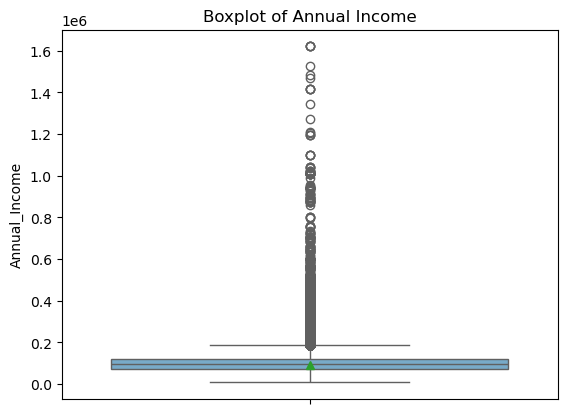

In [22]:
# Boxplot for Annual Income as it seems to have outliers
empty_array = ["" for _ in range(508146)]
sns.boxplot(x=empty_array,
            y=df['Annual_Income'],
            hue=empty_array,
            legend=False,
            showmeans=True,
            palette="Blues")
plt.xticks(rotation=45)
plt.ylabel('Annual_Income')
plt.title('Boxplot of Annual Income')
plt.show()
del(empty_array)

<p>On further investigation of data, we found that the company has some premium customers who own luxury cars and luxury SUVs or multiple SUVs. THese clients mostly have Platinium Tier I or II policies.</p>
<p>These clients can be outliers and the count of these clients is more than the number of detected outliers.</p>
<p>Thus we need to investigate the outliers after partitioning the data on Vehicle Type.</p>

In [23]:
# Partitioning the data in terms of Vehicle_Type
pretty_display(DataFrame(df.groupby('Vehicle_Type')['Annual_Income'].apply(count_iqr_outliers)))

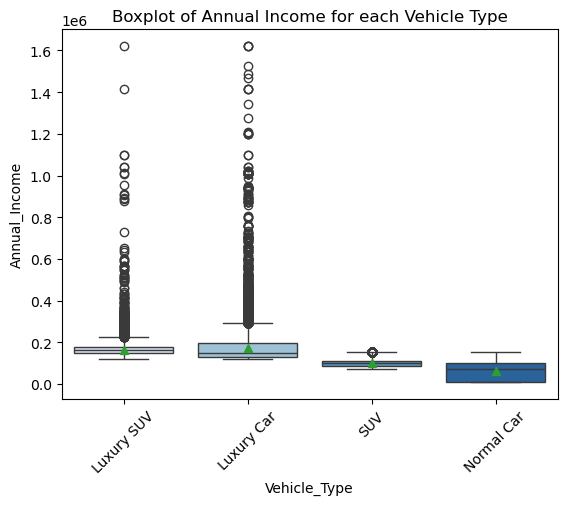

In [24]:
# Boxplot of Annual Income but partitioned on basis of Vehicle type for further analysis of outliers

# Create the boxplot
sns.boxplot(
    x = "Vehicle_Type",  # Set categorical variable on the x-axis (groups)
    y = "Annual_Income",  # Set numerical variable on the y-axis (values)
    hue="Vehicle_Type",
    showmeans=True,  # show mean with a diamond marker
    data=df,
    palette="Blues"
)

# Rotate x labels to prevent overlapping (optional)
plt.xticks(rotation=45)
plt.ylabel('Vehicle_Type')
plt.ylabel('Annual_Income')
plt.title('Boxplot of Annual Income for each Vehicle Type')
plt.show()

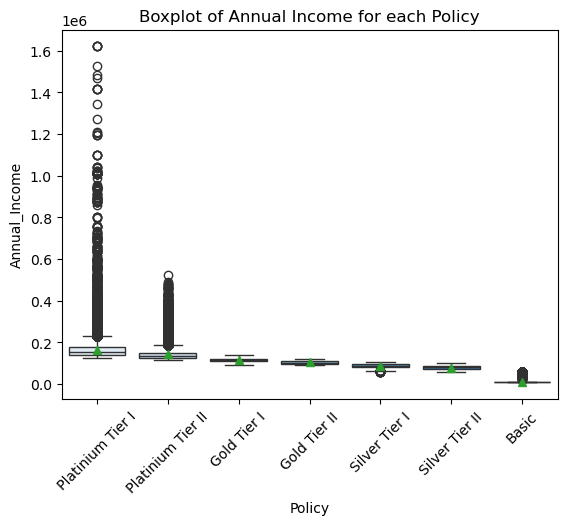

In [25]:
 # Boxplot of Annual Income but partitioned on basis of Vehicle type for further analysis of outliers

# Create the boxplot
sns.boxplot(
    x = "Policy",  # Set categorical variable on the x-axis (groups)
    y = "Annual_Income",  # Set numerical variable on the y-axis (values)
    hue="Policy",
    showmeans=True,  # show mean with a diamond marker
    data=df,
    palette="Blues",
)

# Rotate x labels to prevent overlapping (optional)
plt.xticks(rotation=45)
plt.ylabel('Policy')
plt.ylabel('Annual_Income')
plt.title('Boxplot of Annual Income for each Policy')
plt.show()

<ul>
    <li>A significant number of outliers (2581) were identified after partitioning the data by vehicle type.</li>
<li>Analysis of boxplots suggests that outliers for SUVs might be close to the distribution's boundary and potentially not true outliers.</li>
<li>After excluding potential outliers for SUVs, you're left with 1683 outliers for Luxury Cars and Luxury SUVs.</li>
<li>Domain knowledge suggests outliers in this customer class are expected.</li>
<li>The percentage of remaining outliers (0.3%) falls within an acceptable range.</li>
<li>Also all the outliers are in the premium policies of Platinium Tier I and II.</li>
</ul>

<h2>Data Cleanup</h2>

<p>As the data does not have any duplicates or missing values no scrubbing for duplication or handling of missing values is required.</p>
<p>Checked the datatypes and unique values for the columns and did not find any incorrect data which required fixing.</p>
<p>The outlier analysis also showed that the outliers are critical and should be retained.</p>
<p>Advanced Outlier Analysis will be done later on with DBScan algorithm</p>

<h2>Data Visualization</h2>

<h3>Relation of Policy and Gender</h3>

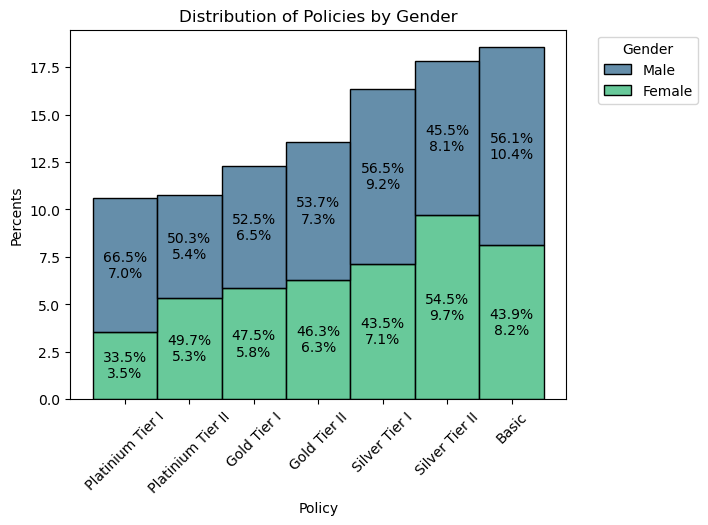

In [26]:
# Create the histogram
g=sns.histplot(x = "Policy",
               hue = "Gender",
               data = df,
               multiple = "stack",
               stat = "percent",
               palette = "viridis") 

# Calculating the percentages
percents = [[f"{level2[0]}%\n{level2[1]}%" for level2 in level1] for level1 in calculate_stack_percentages(df,"Policy","Gender")]
# Add percentage labels using bar_label with formatting
for i,container in enumerate(g.containers):
    g.bar_label(container, labels=percents[len(g.containers)-1-i],
                label_type='center')  # Adjust vertical alignment 

    
# Customize the plot
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1)) 
plt.xlabel("Policy")
plt.ylabel("Percents")
plt.title("Distribution of Policies by Gender")
plt.xticks(rotation=45)
plt.show()
del(g,percents)

<p><u><i>Please note: For all further stacked bar plots </i></u></p>
 <p>The first percent is the percentage of the particular stack in it's bar </p>
<p>The second percent is the percentage of the particular stack in all the bars </p>

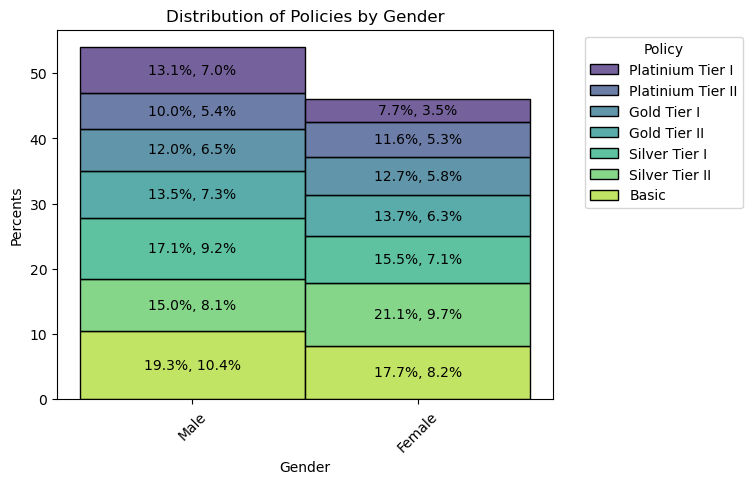

In [27]:
# Create the histogram
g=sns.histplot(x = "Gender",
               hue = "Policy",
               data = df,
               multiple = "stack",
               stat = "percent",
               palette = "viridis")  

# Calculating the percentages

percents = [[f"{level2[0]}%, {level2[1]}%" for level2 in level1] for level1 in calculate_stack_percentages(df,"Gender","Policy")]
# Add percentage labels using bar_label with formatting
for i,container in enumerate(g.containers):
    g.bar_label(container, labels=percents[len(g.containers)-1-i],
                label_type='center')  # Adjust vertical alignment

    
# Customize the plot
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1)) 
plt.xlabel("Gender")
plt.ylabel("Percents")
plt.title("Distribution of Policies by Gender")
plt.xticks(rotation=45)

plt.show()
del(g,percents)

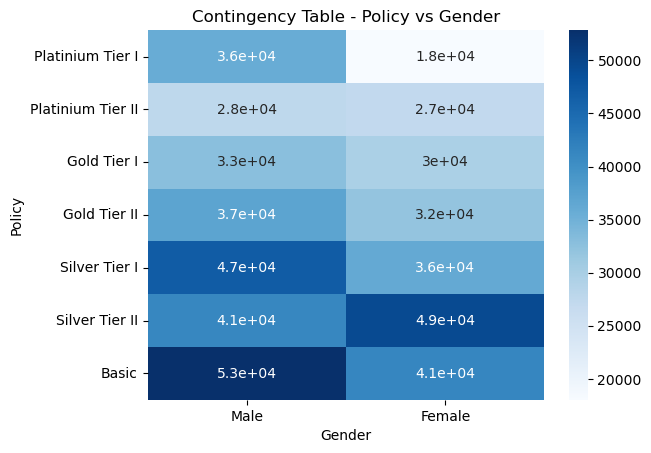

In [28]:
# Create a heatmap directly from the DataFrame
sns.heatmap(crosstab(df['Policy'], df['Gender']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Gender')
plt.ylabel('Policy')
plt.title('Contingency Table - Policy vs Gender')
plt.show()

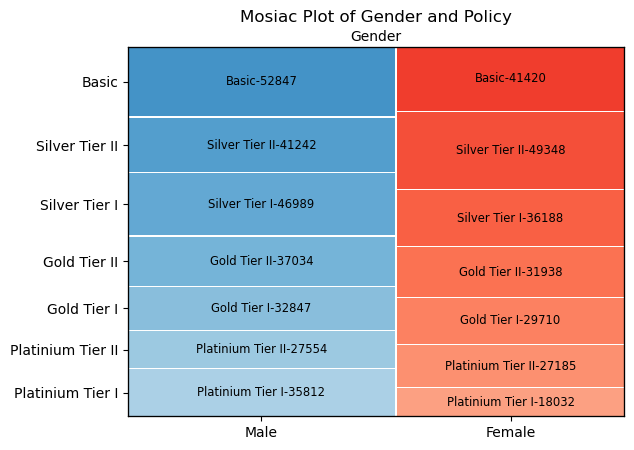

In [29]:
 # Generate mosaic plot
plot_mosiac(df,'Gender','Policy',cmap_list=["Blues","Reds"])

# Customize the plot
plt.xlabel("Gender")
plt.ylabel("Policy")
plt.title("Mosiac Plot of Gender and Policy")
plt.show()

In [30]:
detailed_crosstab(df,"Gender","Policy")

<h4>Data Analysis</h4>
<ul>
<li<p><u>Silver Tier II Popularity among Women</u>: Silver Tier II stands out as the most popular tier for our female clients capturing 21.11% of the female market. It is our only product where female customers exceed the number of male customers. This presents a unique opportunity to tailor marketing specifically for females interested in Silver Tier coverage.</p></li>
<li<p><u>Platinium Tier I Gender Skew</u>: Platinium Tier I shows the strongest gender skew, with 66.51% being male policyholders. Further investigation is needed to understand why Platinum Tier I attracts fewer females and identify features that might be more appealing to this demographic.</p></li>
</ul>
<h4>Marketing Oppurtunities</h4>
<ul>
<li>
<p><u>Targeted Marketing Campaigns</u>: Marketing teams can design targeted campaigns for Silver Tier II for our female clients. For example, they could highlight features that resonate more with females in their Silver Tier II marketing materials.</p>
<p><u>Promotion Campaigns for Platinium Tier I for female demographic</u>: Promote Platinium Tier I through female-centric media outlets. Consider influencer partnerships with women who value car safety, to attract female customers towards our premium policy.  Develop limited-time promotions or discounts specifically for female customers considering Platinum Tier I coverage.</p>
</li>
</ul>

<h4>Product Development Opportunities</h4>
<ul>
<li><p><u>Feature Analysis</u>:  Collaborate with the product team to delve deeper into what specific features within Silver Tier II make it popular among the female demographic. We can try to incorporate these features as custom add-ons in other products as well to make them attractive to women.</p></li>

<li><p><u>Product Differentiation for Platinium Tier I</u>:  Product teams can explore reasons behind the gender gap in Platinum Tiers. From feature analysis of Silver Tier II, the product team can customize Platinium Tier I, to make it more attractive to the female demographic.</p></li>
</ul>

<h3>Relation of Policy and Age</h3>      


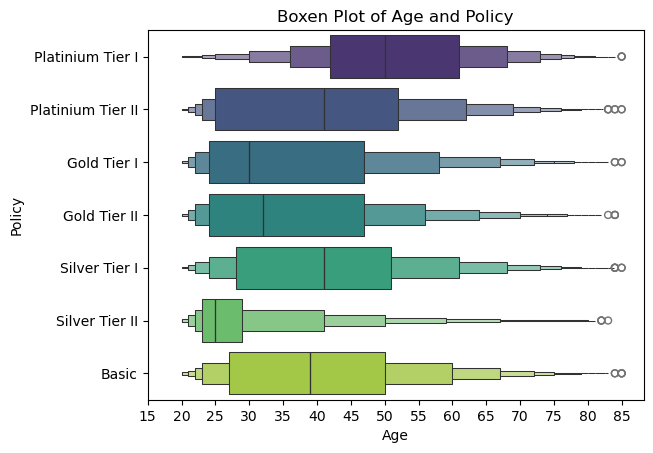

In [31]:
sns.boxenplot(x = "Age",
              y = "Policy",
              data = df,
              hue = "Policy", 
              palette = "viridis")

# Customize the plot
plt.title("Boxen Plot of Age and Policy")
plt.xticks(range(15,87,5))
plt.show()

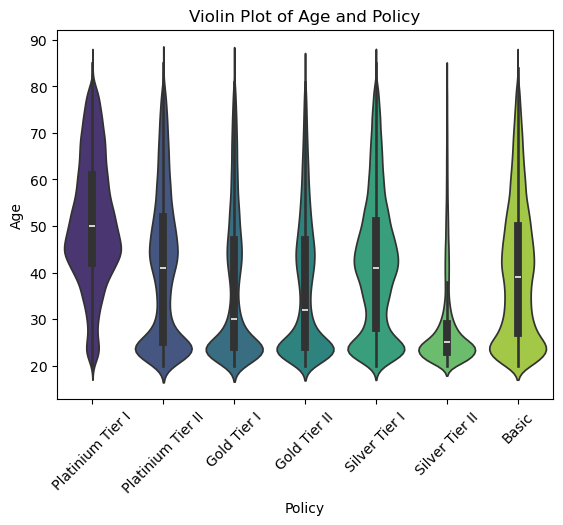

In [32]:
 # Create the violin plot
sns.violinplot(x = "Policy",
               y = "Age",
               data = df,
               hue = "Policy",
               palette = "viridis")

# Customize the plot
plt.xlabel("Policy")
plt.ylabel("Age")
plt.title("Violin Plot of Age and Policy")
plt.xticks(rotation=45)
plt.show()

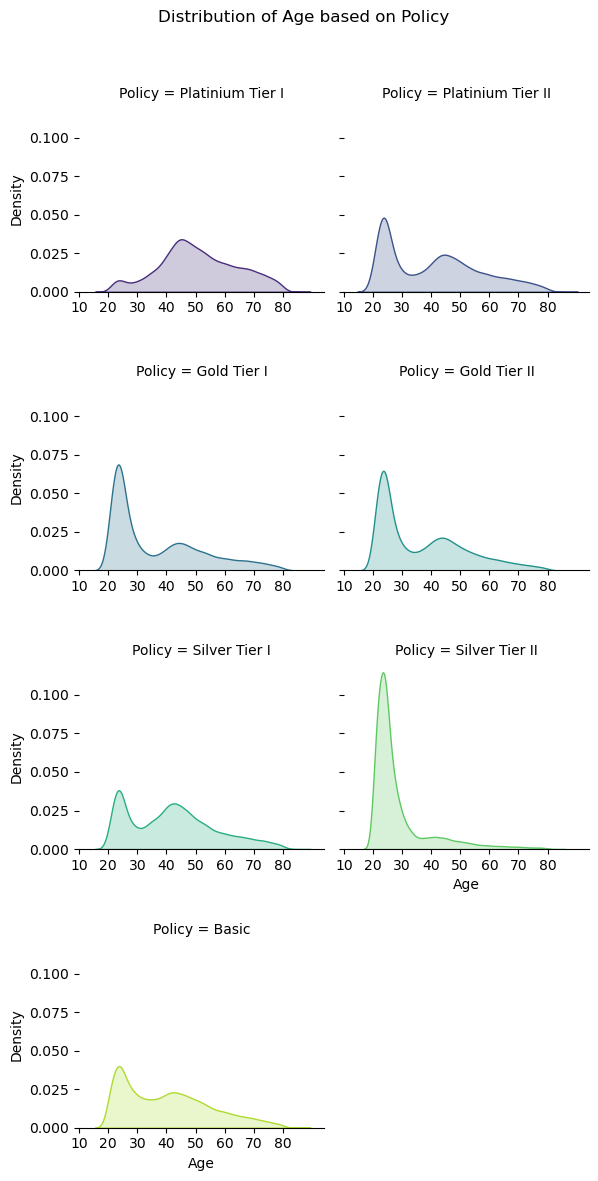

In [33]:
# Kernel density estimation (KDE) plot for each policy type
g = sns.FacetGrid(df, col = "Policy",
                  hue = 'Policy',
                  palette = 'viridis',
                  col_wrap = 2)

# Plot KDE on each facet with hue for age
g.map(sns.kdeplot, "Age", fill=True, common_norm=False, bw_adjust=1)  # Adjust alpha for transparency

# Customize the plot
plt.xlabel("Age")
plt.ylabel("Density")
plt.xticks(range(10,90,10))

for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

# Remove extra rug plots (optional for cleaner look)
sns.despine(left=True)
g.fig.suptitle("Distribution of Age based on Policy")  # Add main title
plt.subplots_adjust(top=0.9,hspace=0.5)          
plt.show()
del(g)


In [34]:
# Display the table showing the relation between i and 
pretty_display(df.groupby("Policy")["Age"].agg(["mean","min",first_quantile,
                                                "median",third_quantile,"max",IQR,"std","count"]))

<h4>Data Analysis</h4>
<ul>
<li<p><u>Similiar Trend for Most of the Policies</u>: Most policies cater to a broad age range, with a concentration between 25-50 years old.
The standard deviation for customer age across most policies is around 15 years, indicating a significant spread.
Two exceptions are Silver Tier II and Platinum Tier I, which have a somewhat narrower customer age range.</p></li>
<li<p><u>Platinium Tier I Popularity among Middle-Aged Adults</u>: Platinium Tier I has a concentration of customers between the ages 42-61 years old. This shows that Platinium Tier I is the most popular policy among Middle-Aged Adults. </p></li>
<li<p><u>Silver Tier II Popularity among Youth</u>: Silver Tier II has most of its customers below the age of 30 years. It is the best-performing policy among the youth. </p></li>
</ul>
<h4>Marketing Oppurtunities</h4>
<ul>
<li>
<p><u>Targeted Marketing Campaigns</u>:   Platinum tier I marketing material could focus on mature drivers seeking comprehensive coverage, while Silver Tier II marketing could target young adults looking for affordable coverage. Targeted marketing will help to get more customers from both demographics by promoting products that the respective age groups prefer.</p>
<p><u>Digital Marketing Strategy</u>: Utilize digital channels like social media and search engines to reach younger demographics (Silver Tier II) who are more likely to engage online. Leverage traditional channels like mailers or television ads for older demographics (Platinum Tier I).</p>
</li>
</ul>

<h4>Product Development Opportunities</h4>
<ul>
<li><p><u>Feature Analysis</u>:  Collaborate with the product team to delve deeper into what specific features within Silver Tier II and Platinium Tier I make them popular among their respective age groups. We can make these features as custom add-ons or riders for our other policies, and promote them to their respective age group.</p></li>

<li><p><u>Product Development</u>: Consider developing age-specific features or discounts within Platinium Tier I and Silver Tier II so that it can better serve its targetted demographic. For example, Platinum Tier I could offer additional benefits like roadside assistance or medical payment coverage, catering to the needs of older drivers. Silver Tier II could focus on providing basic coverage at competitive rates to attract young drivers.</p></li>
</ul>

<h3>Relation of Policy and Region</h3>

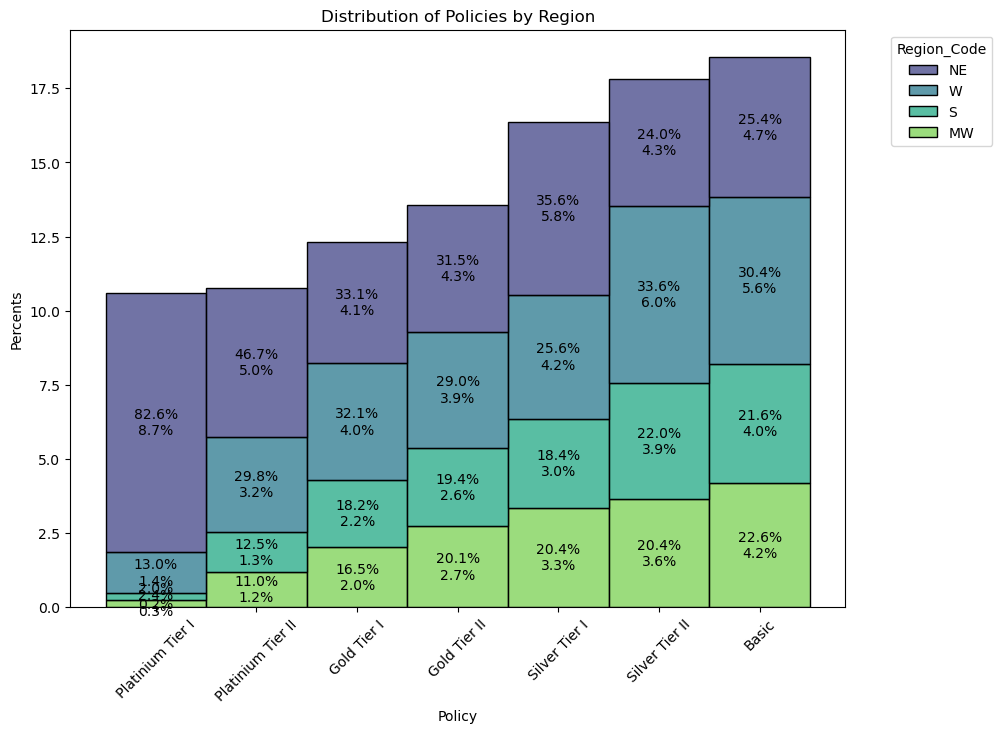

In [35]:
# Create the histogram
plt.figure(figsize=(10, 7.5))
g=sns.histplot(x = "Policy",
               hue = "Region_Code",
               data = df,
               multiple = "stack",
               stat = "percent",
               palette = "viridis") 

# Calculating the percentages
percents = [[f"{level2[0]}%\n{level2[1]}%" for level2 in level1] for level1 in calculate_stack_percentages(df,"Policy","Region_Code")]
# Add percentage labels using bar_label with formatting
for i,container in enumerate(g.containers):
    g.bar_label(container, labels=percents[len(g.containers)-1-i],
                label_type='center')  # Adjust vertical alignment 

    
# Customize the plot
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1)) 
plt.xlabel("Policy")
plt.ylabel("Percents")
plt.title("Distribution of Policies by Region")
plt.xticks(rotation=45)
plt.show()

del(g,percents)

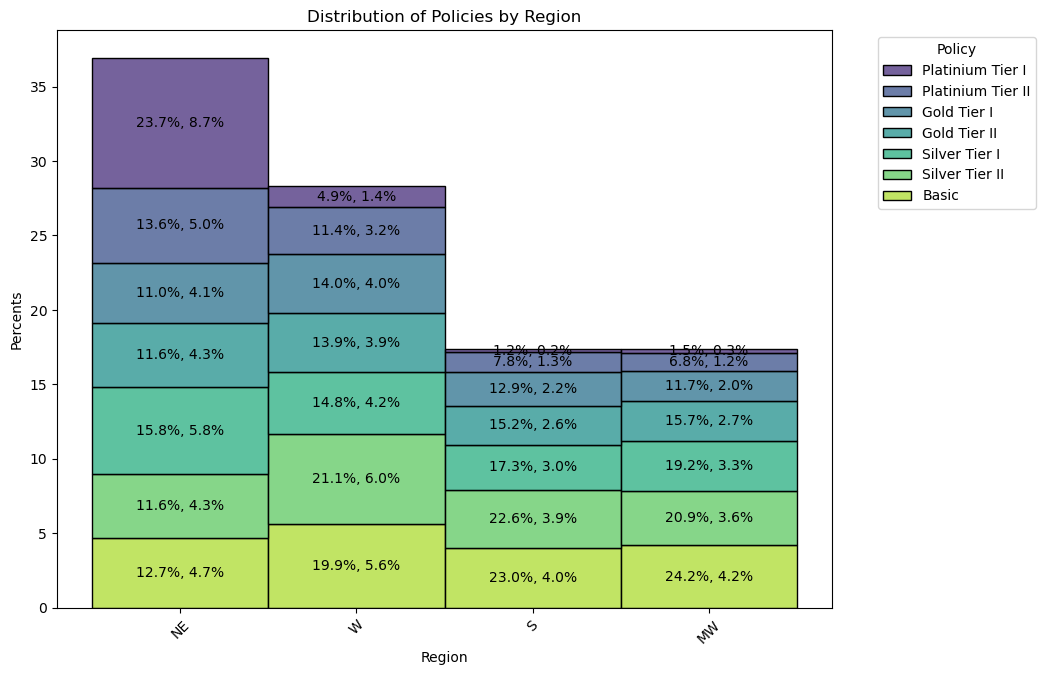

In [36]:
# Create the histogram
plt.figure(figsize=(10, 7.5))
g=sns.histplot(x = "Region_Code",
               hue = "Policy",
               data = df,
               multiple = "stack",
               stat = "percent",
               palette = "viridis")  

# Calculating the percentages

percents = [[f"{level2[0]}%, {level2[1]}%" for level2 in level1] for level1 in calculate_stack_percentages(df,"Region_Code","Policy")]
# Add percentage labels using bar_label with formatting
for i,container in enumerate(g.containers):
    g.bar_label(container, labels=percents[len(g.containers)-1-i],
                label_type='center')  # Adjust vertical alignment

    
# Customize the plot
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1)) 
plt.xlabel("Region")
plt.ylabel("Percents")
plt.title("Distribution of Policies by Region")
plt.xticks(rotation=45)

plt.show()
del(g,percents)

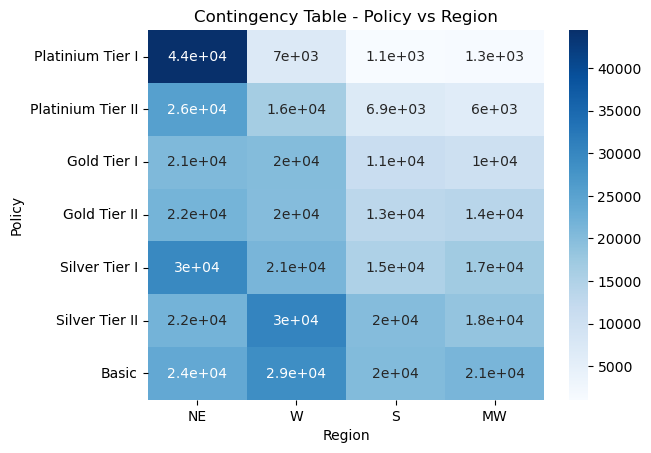

In [37]:
# Create a heatmap directly from the DataFrame
sns.heatmap(crosstab(df['Policy'], df['Region_Code']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Region')
plt.ylabel('Policy')
plt.title('Contingency Table - Policy vs Region')
plt.show()

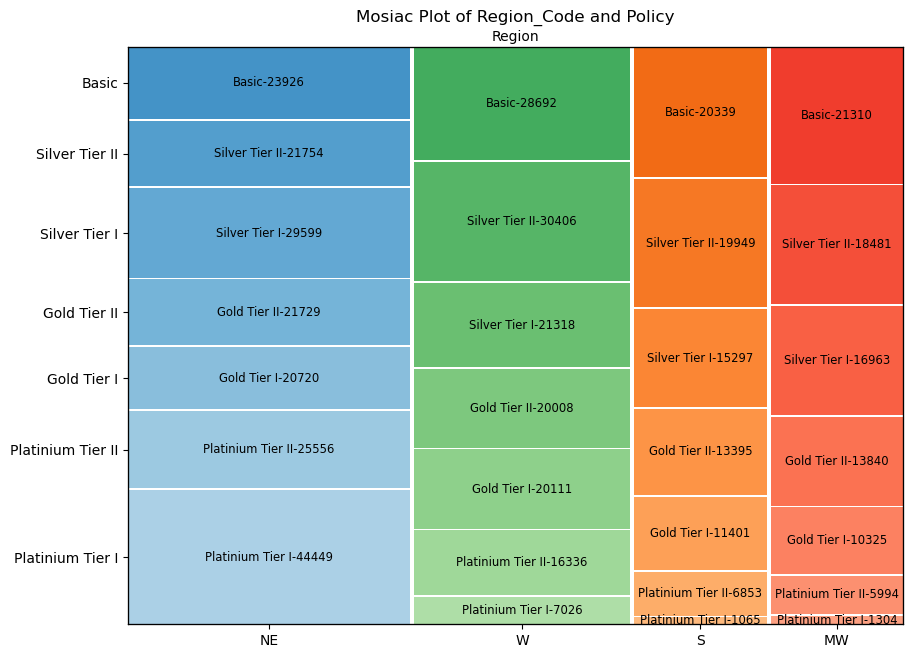

In [38]:
 # Generate mosaic plot
with plt.rc_context({"figure.figsize":(10,7.5)}):
    plot_mosiac(df,'Region_Code','Policy',cmap_list=["Blues","Greens","Oranges","Reds"])
    
    # Customize the plot
    plt.xlabel("Region")
    plt.ylabel("Policy")
    plt.title("Mosiac Plot of Region_Code and Policy")
    plt.show()

In [39]:
detailed_crosstab(df,"Region_Code","Policy")

<h4>Analysis</h4>
<p>The Analysis of Region is done along with Location_Type in the next section.</p>

<h3>Relation of Policy and Location_Type</h3>

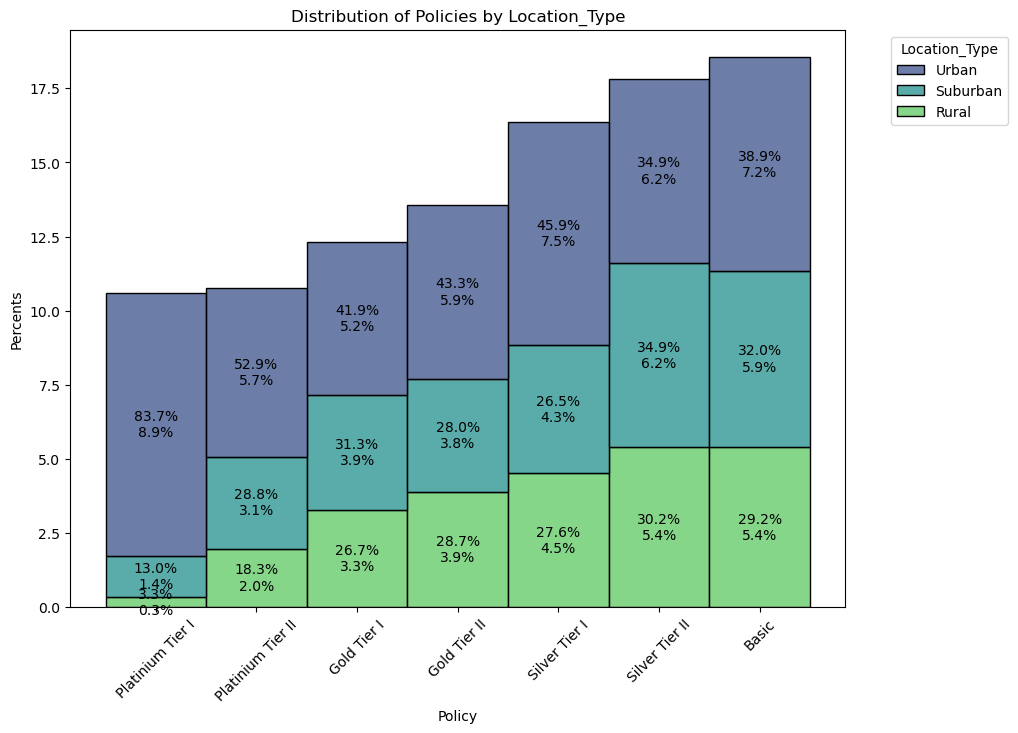

In [40]:
# Create the histogram
plt.figure(figsize=(10, 7.5))
g=sns.histplot(x = "Policy",
               hue = "Location_Type",
               data = df,
               multiple = "stack",
               stat = "percent",
               palette = "viridis") 

# Calculating the percentages
percents = [[f"{level2[0]}%\n{level2[1]}%" for level2 in level1] for level1 in calculate_stack_percentages(df,"Policy","Location_Type")]
# Add percentage labels using bar_label with formatting
for i,container in enumerate(g.containers):
    g.bar_label(container, labels=percents[len(g.containers)-1-i],
                label_type='center')  # Adjust vertical alignment 

    
# Customize the plot
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1)) 
plt.xlabel("Policy")
plt.ylabel("Percents")
plt.title("Distribution of Policies by Location_Type")
plt.xticks(rotation=45)
plt.show()

del(g,percents)

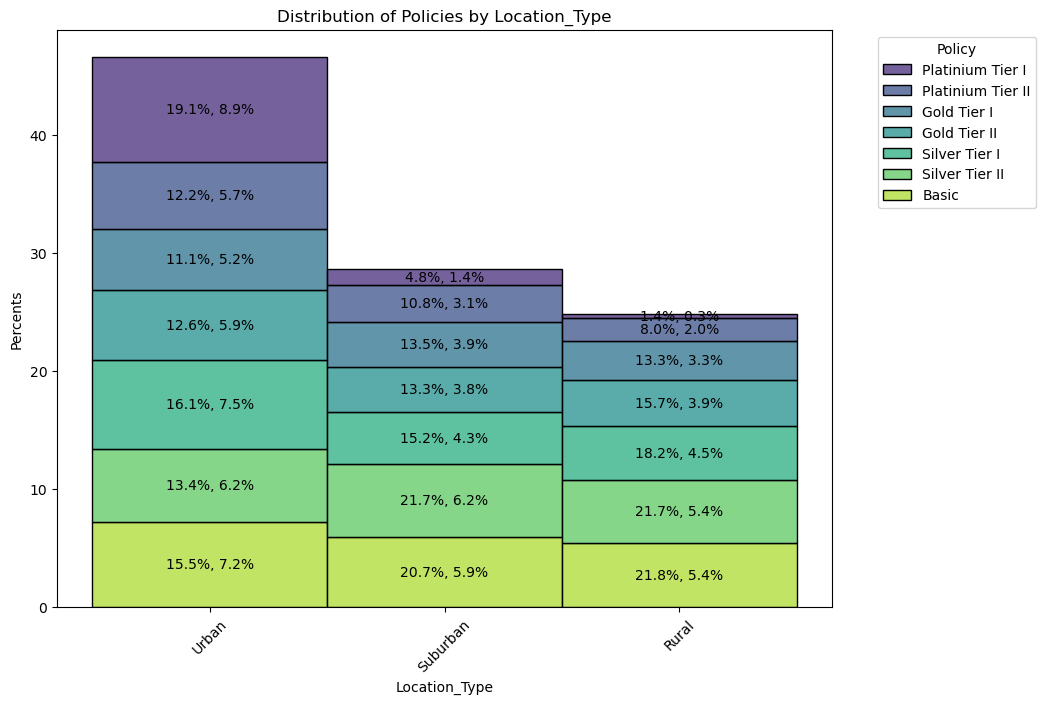

In [41]:
# Create the histogram
plt.figure(figsize=(10, 7.5))
g=sns.histplot(x = "Location_Type",
               hue = "Policy",
               data = df,
               multiple = "stack",
               stat = "percent",
               palette = "viridis")  

# Calculating the percentages

percents = [[f"{level2[0]}%, {level2[1]}%" for level2 in level1] for level1 in calculate_stack_percentages(df,"Location_Type","Policy")]
# Add percentage labels using bar_label with formatting
for i,container in enumerate(g.containers):
    g.bar_label(container, labels=percents[len(g.containers)-1-i],
                label_type='center')  # Adjust vertical alignment

    
# Customize the plot
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1)) 
plt.xlabel("Location_Type")
plt.ylabel("Percents")
plt.title("Distribution of Policies by Location_Type")
plt.xticks(rotation=45)

plt.show()
del(g,percents)

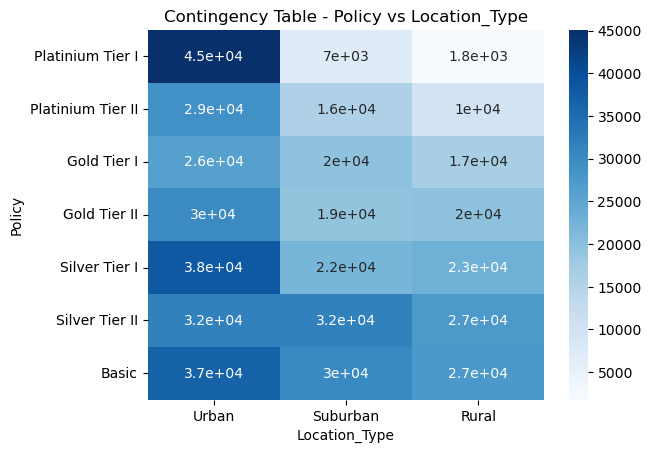

In [42]:
# Create a heatmap directly from the DataFrame
sns.heatmap(crosstab(df['Policy'], df['Location_Type']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Location_Type')
plt.ylabel('Policy')
plt.title('Contingency Table - Policy vs Location_Type')
plt.show()

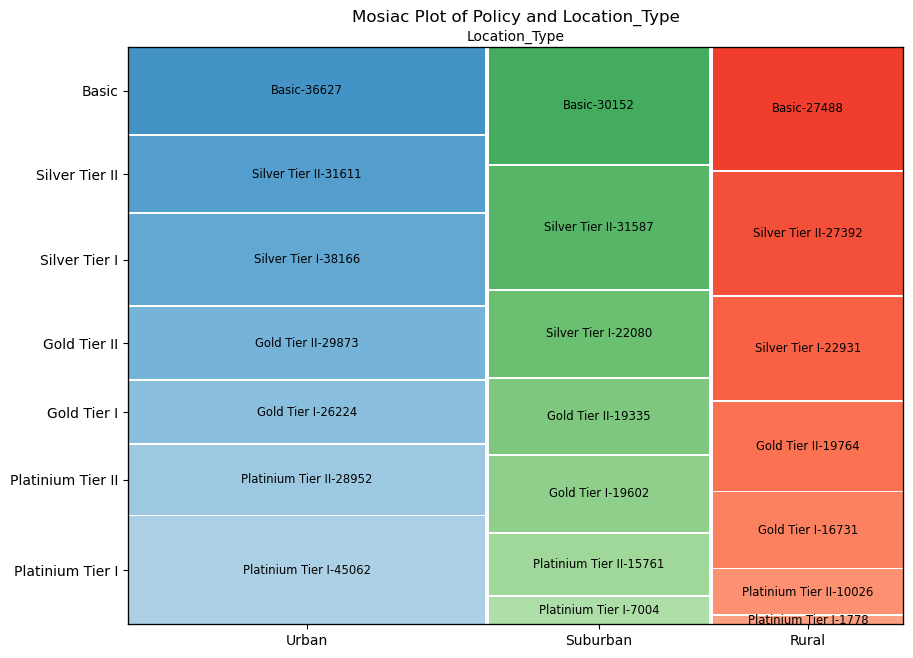

In [43]:
 # Generate mosaic plot
with plt.rc_context({"figure.figsize":(10,7.5)}):
    plot_mosiac(df,'Location_Type','Policy',cmap_list=["Blues","Greens","Reds"])
    
    # Customize the plot
    plt.xlabel("Location_Type")
    plt.ylabel("Policy")
    plt.title("Mosiac Plot of Policy and Location_Type")
    plt.show()

In [44]:
detailed_crosstab(df,"Location_Type","Policy")

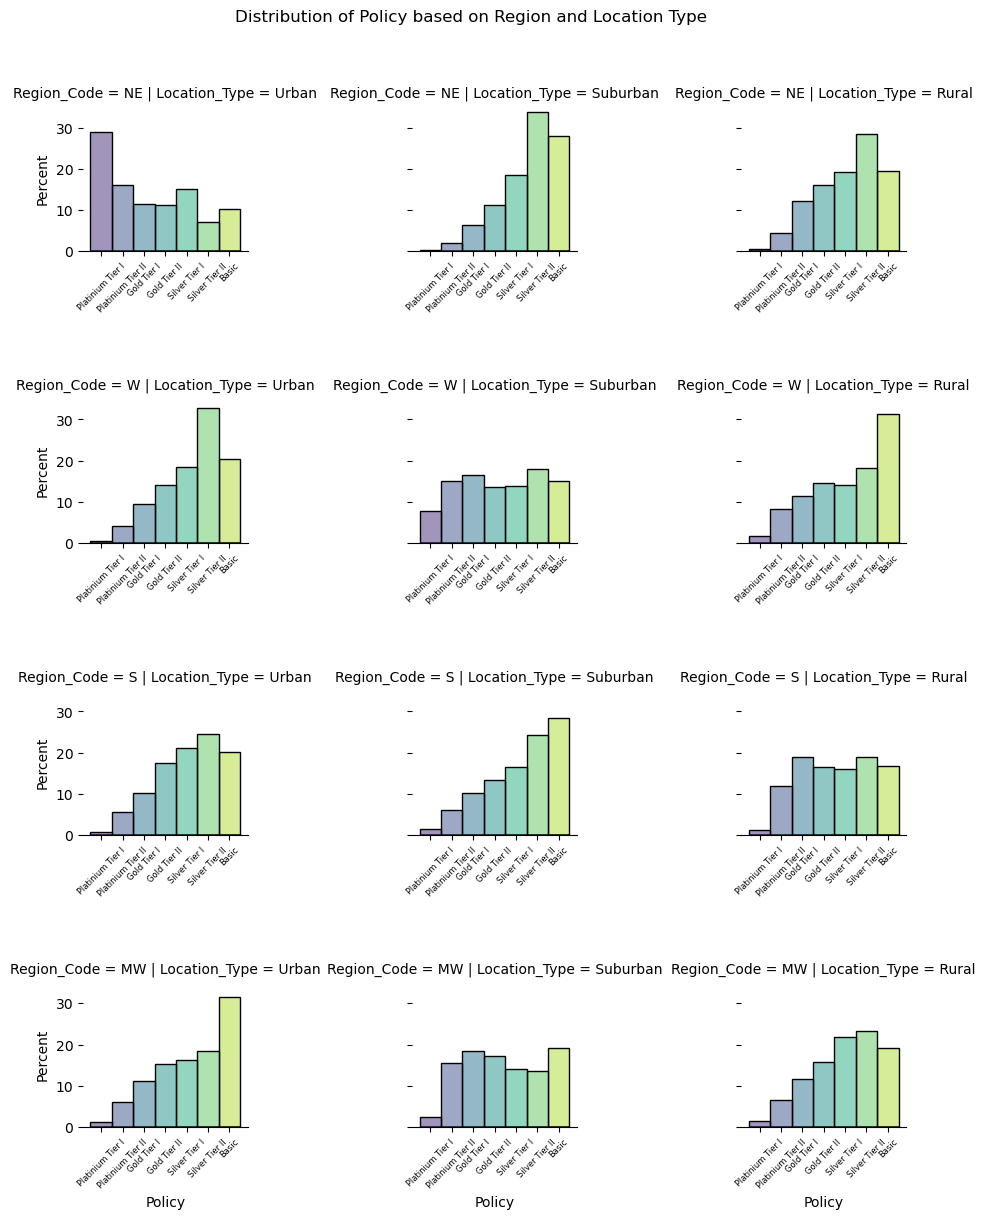

In [45]:
with plt.rc_context({"figure.figsize":(16,25)}):
    # Kernel density estimation (KDE) plot for each policy type
    g = sns.FacetGrid(df.sort_values("Policy"), col = "Location_Type",row = "Region_Code")
    
    # Plot KDE on each facet with hue for age
    g.map(sns.histplot, "Policy", stat="percent",hue=df["Policy"],palette="viridis")  # Adjust alpha for transparency
    
    # Customize the plot
    plt.xlabel("Policy")
    plt.ylabel("Density")

    for ax in g.axes.flatten():
        ax.tick_params(labelbottom=True)
    
    # Remove extra rug plots (optional for cleaner look)
    sns.despine(left=True)
    g.fig.suptitle("Distribution of Policy based on Region and Location Type")  # Add main title
    g.set_xticklabels (rotation=45, fontsize=6)
    plt.subplots_adjust(top=0.9,hspace=1.0,wspace=1.0)          
    plt.show()

del(g)


<h4>Analysis</h4>
<ul>
<li><u>NE Market Sweet Spot</u>: Platinum Tier I policy dominates sales within the urban areas of NE region.</li>
<li><u>Unexploited Potential</u>: This policy's success in the NE urban areas suggests an opportunity for expanding its reach geographically to other regions.</li>
</ul>
<h4>Marketing Suggestions</h4>
<ul>
<li><p><u>Targeted Marketing Campaigns</u>: Design targeted campaigns to promote Platinum Tier I specifically in the urban areas of NE to capitalize on existing demand. Additionally, explore the expansion of these promotions to other regions with the potential for high adoption.</p></li>
</ul>
<h4>Product Development Opportunities</h4>
<ul>
<li><p><u>Platinium Tier I Product Development</u>: Collaborate with the product team to understand the reasons behind the urban area of NE's preference for Platinum Tier I. Investigate if specific features within the policy make it less attractive in other regions. Consider tailoring the policy's features or developing regional variations to enhance its appeal in other markets.</p></li>
<li><p><u>Customer Behaviour Analysis and Pilot Program</u>: Analyze customer behavior in other regions to identify potential gaps or misalignments with Platinum Tier I features. Develop a pilot program to test variations of the Platinum Tier I policy in select non-NE regions.</p></li>
</ul>

<h3>Relation of Education and Policy</h3>

<p>Plotting Doctors and High Schools separately as they are in a minority class in our customer base. As Education is an unbalanced class, bar charts are not being plotted.</p>

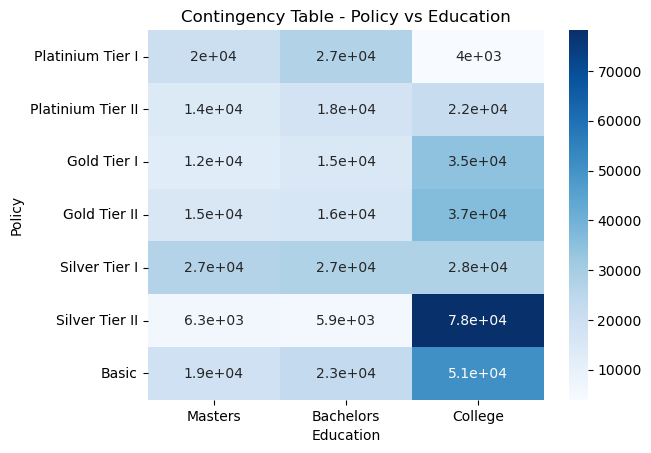

In [46]:
# Create a heatmap directly from the DataFrame
filtered_df = df[df["Education"].isin(["College","Bachelors","Masters"])]
sns.heatmap(crosstab(filtered_df['Policy'], filtered_df['Education']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Education')
plt.ylabel('Policy')
plt.title('Contingency Table - Policy vs Education')
plt.show()
del(filtered_df)

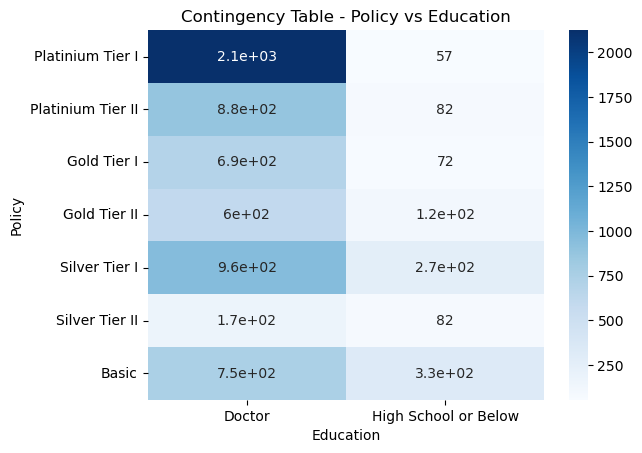

In [47]:
# Create a heatmap directly from the DataFrame
filtered_df = df[~df["Education"].isin(["College","Bachelors","Masters"])]
sns.heatmap(crosstab(filtered_df['Policy'], filtered_df['Education']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Education')
plt.ylabel('Policy')
plt.title('Contingency Table - Policy vs Education')
plt.show()
del(filtered_df)

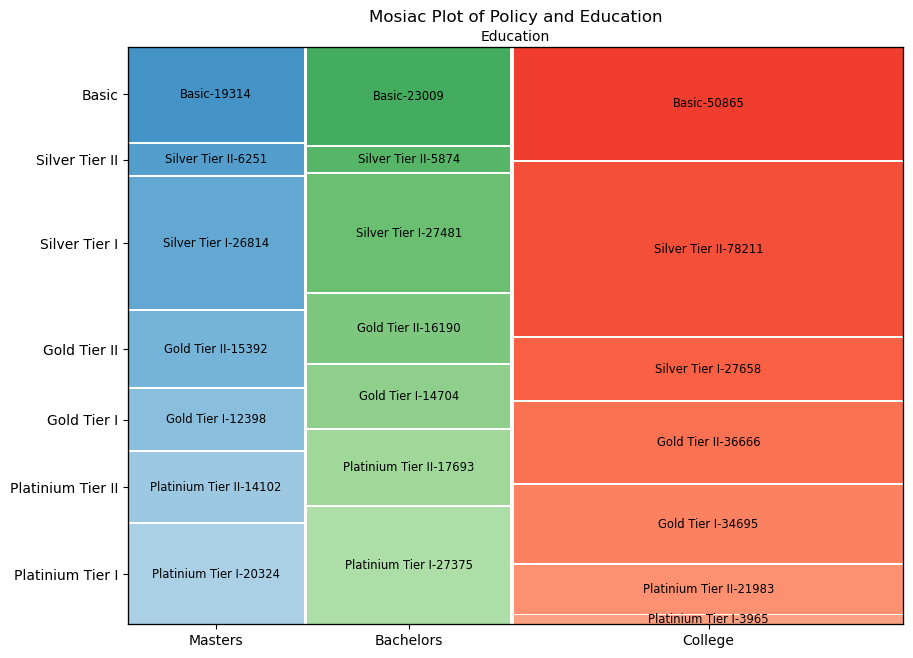

508146


In [48]:
 # Generate mosaic plot
filtered_df = df[df["Education"].isin(["Masters","Bachelors","College"])]
filtered_df["Education"] = Categorical(filtered_df["Education"],["Masters","Bachelors","College"],ordered=True)

with plt.rc_context({"figure.figsize":(10,7.5)}):
    plot_mosiac(filtered_df,'Education','Policy',cmap_list=["Blues","Greens","Reds"])
    
    # Customize the plot
    plt.xlabel("Education")
    plt.ylabel("Policy")
    plt.title("Mosiac Plot of Policy and Education")
    plt.show()

print(len(df))
del(filtered_df)

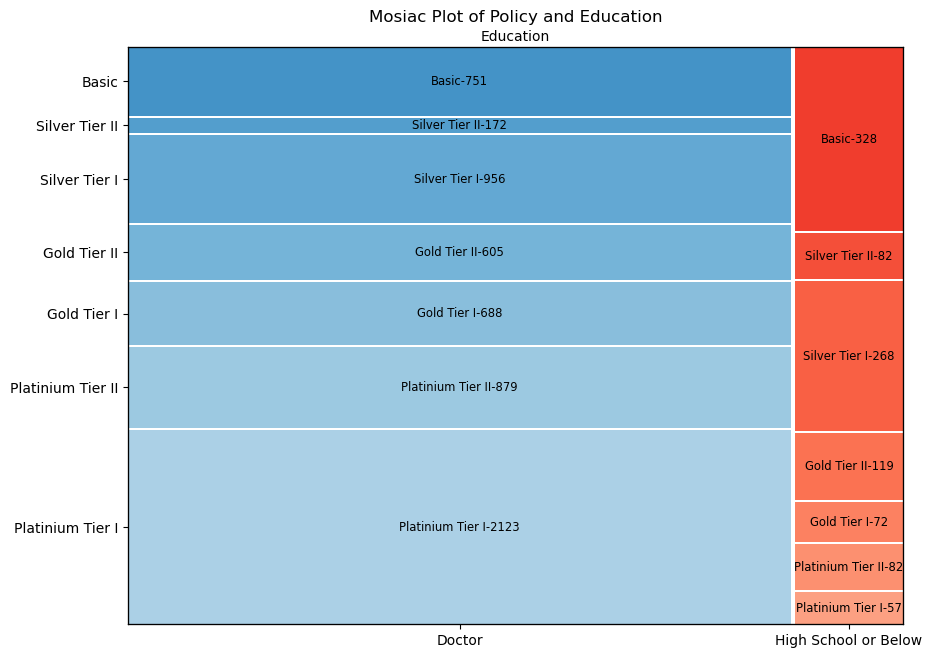

In [49]:
filtered_df = df[df["Education"].isin(["Doctor","High School or Below"])]
filtered_df["Education"] = Categorical(filtered_df["Education"],["Doctor","High School or Below"],ordered=True)
# Generate mosaic plot
with plt.rc_context({"figure.figsize":(10,7.5)}):
    plot_mosiac(filtered_df,'Education','Policy',cmap_list=["Blues","Reds"])
    
    # Customize the plot
    plt.xlabel("Education")
    plt.ylabel("Policy")
    plt.title("Mosiac Plot of Policy and Education")
    plt.show()
    
del(filtered_df)

In [50]:
detailed_crosstab(df,"Education","Policy")

<h4>Analysis</h4>
<ul>
<li><u>Educational Attainment Distribution</u>: Platinum Tier policies dominate sales with customers with higher educational levels like Bachelor, Master, and Doctor. Similarly, Basic and Silver Tier policies dominate the lower education demographic of College, High School or lower.</li>
<li>Unexploited Potential: This policy's success in the NE urban areas suggests an opportunity for expanding its reach geographically to other regions.</li>
</ul>
<h4>Marketing Suggestions</h4>
<ul>
<li><p><u>Targeted Marketing Campaigns</u>: Develop targeted marketing campaigns for each tier based on the educational attainment demographics. For instance, Platinum tier marketing could focus on professionals with advanced degrees, while Basic and Silver Tier Policies could target a broader audience.</p></li>
<li><p><u>Targeted Marketing Campaigns</u>:  Craft content marketing materials that resonate with different educational segments. Utilize publications or online resources frequented by Graduates or above (Platinum Tier) compared to targeting materials towards audiences with a college, high school education or below (Basic Tier).</p></li>
</ul>
<h4>Product Development Opportunities</h4>
<ul>
<li><p><u>Product Development</u>: Consider developing features or add-on coverage options that cater to the specific needs of policyholders with higher educational attainment. For example, the Platinum Tier could offer additional benefits like increased rental car coverage or theft protection. For Basic and Silver Tier Policies the features and terms could be made simpler so that they would be attractive to lower education demographic.</p></li>
</ul>

<h3> Relation between Policy and Annual Income </h3>

<p>Due to outliers in the Annual_Income to get a better visualization we have plotted only Annual Income less than $ 0.25 million</p>

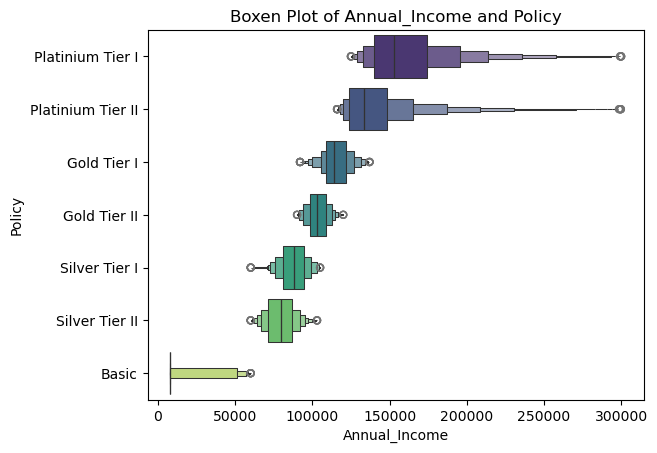

In [51]:
sns.boxenplot(x = "Annual_Income",
              y = "Policy",
              data = df[df["Annual_Income"]<300_000],
              hue = "Policy", 
              palette = "viridis")

# Customize the plot
plt.title("Boxen Plot of Annual_Income and Policy")
plt.show()

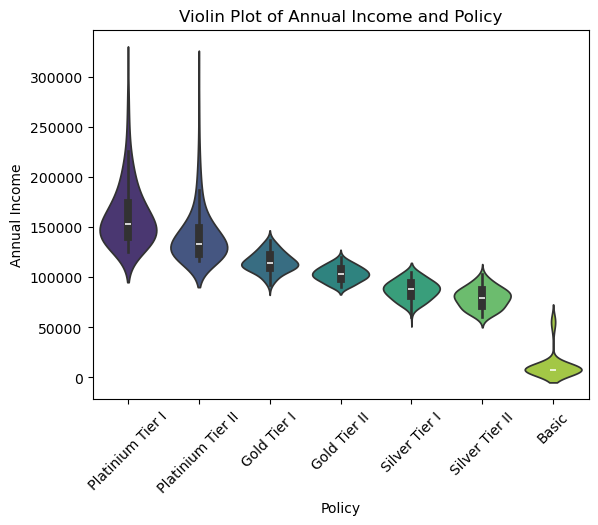

In [52]:
# Create the violin plot
sns.violinplot(x = "Policy",
               y = "Annual_Income",
               data = df[df["Annual_Income"]<300_000],
               hue = "Policy",
               palette = "viridis",
               bw_method=0.5)

# Customize the plot
plt.xlabel("Policy")
plt.ylabel("Annual Income")
plt.title("Violin Plot of Annual Income and Policy")
plt.xticks(rotation=45)
plt.show()

In [53]:
# Display the table showing the relation between i and 
pretty_display(df.groupby("Policy")["Annual_Income"].agg(["mean","min",first_quantile,
                                                "median",third_quantile,"max",IQR,"std","count"]))

In [54]:
print(df["Annual_Income"].corr(df["Age"]))

0.0673919239773605


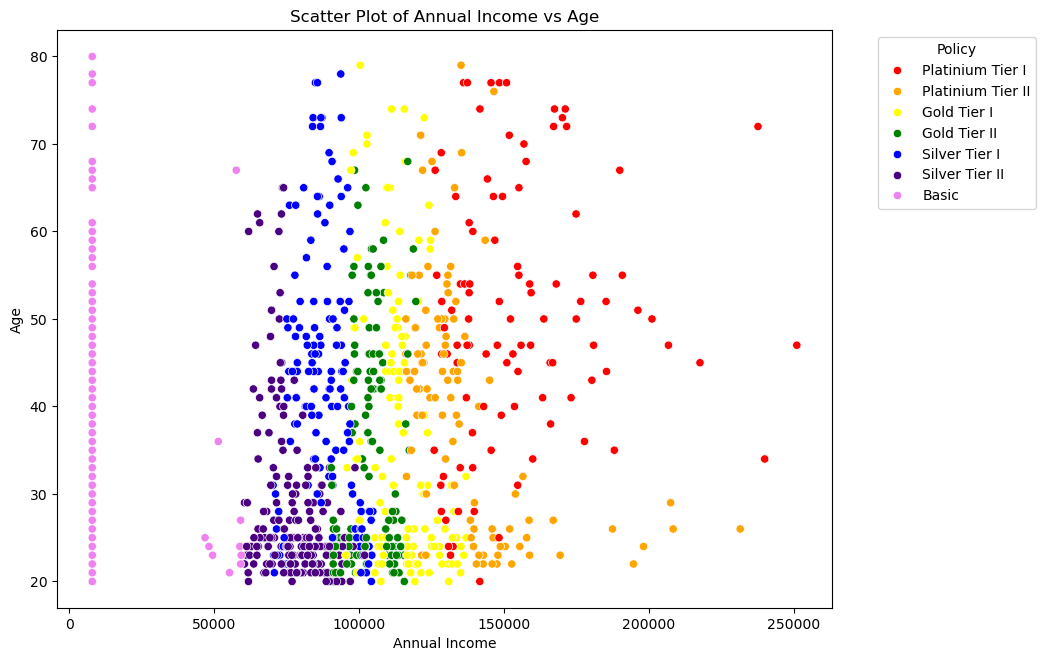

In [55]:
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']
rainbow_colors = sns.color_palette(colors)

# Plotting a scatter plot for comparison of Policy with the two numeric variables Annual Income and Age 
plt.figure(figsize=(10, 7.5))
g=sns.scatterplot(data = df[df["Annual_Income"]<300_000].sample(1000,random_state=21),
                  y = "Age", 
                  x = "Annual_Income",
                  hue = "Policy",
                  palette = rainbow_colors)
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1)) 
plt.xlabel("Annual Income")
plt.ylabel("Age")
plt.title("Scatter Plot of Annual Income vs Age")
plt.show()

<h4>Analysis</h4>
<ul>
<li><p> <u>Income Distribution</u>: There's a clear correlation between annual income and policy tier selection. Customers with higher incomes tend to gravitate towards higher tiers (Platinum and Gold) than those with lower incomes.</p></li>
</ul>
<h4>Marketing Suggestions</h4>
<ul>
<li><p><u>Targetted Messaging</u>: Develop targeted marketing campaigns for each tier based on the income demographics. For instance, Platinum and Gold Tier, marketing could focus on high-income earners, while Silver and Basic Tier, marketing could target budget-conscious audiences..</p></li>
<li><p><u>Channel Strategy </u>: Utilize marketing channels that resonate with different income segments. Consider premium channels like print magazines or financial websites for high-income audiences (Platinum and Gold Tier). Conversely, leverage digital channels and social media for broader outreach (Silver Tier, Basic)  </p></li>
</ul>

<h4>Product Development Opportunities</h4>

<p><u>Product Development</u>: Consider developing features or coverage options that cater to the specific needs of high-income customers. For example, the Platinum Tier could offer additional benefits like increased rental car coverage theft protection.</p>

<h3> Relation between Policy and Vehicle Type </h3>

<p>Plotting the Luxury and Normal Vehicles seperately as the count for these vehicles is significantly different.</p>

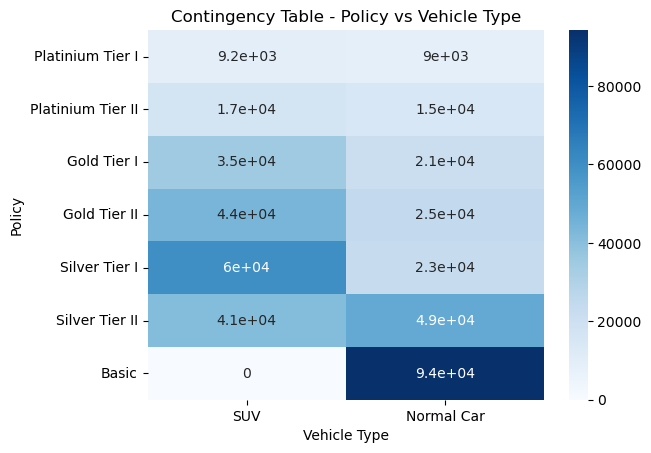

In [56]:
# Create a heatmap directly from the DataFrame
filtered_df = df[df["Vehicle_Type"].isin(["Normal Car","SUV"])]
sns.heatmap(crosstab(filtered_df['Policy'], filtered_df['Vehicle_Type']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Vehicle Type')

plt.ylabel('Policy')
plt.title('Contingency Table - Policy vs Vehicle Type')
plt.show()
del(filtered_df)

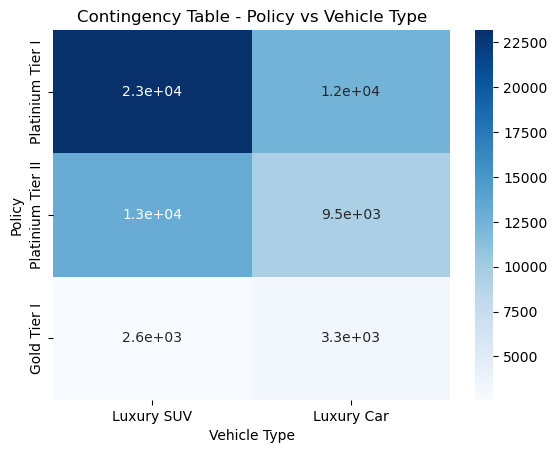

In [57]:
# Create a heatmap directly from the DataFrame
filtered_df = df[~df["Vehicle_Type"].isin(["Normal Car","SUV"])]
sns.heatmap(crosstab(filtered_df['Policy'], filtered_df['Vehicle_Type']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Vehicle Type')
plt.ylabel('Policy')
plt.title('Contingency Table - Policy vs Vehicle Type')
plt.show()
del(filtered_df)

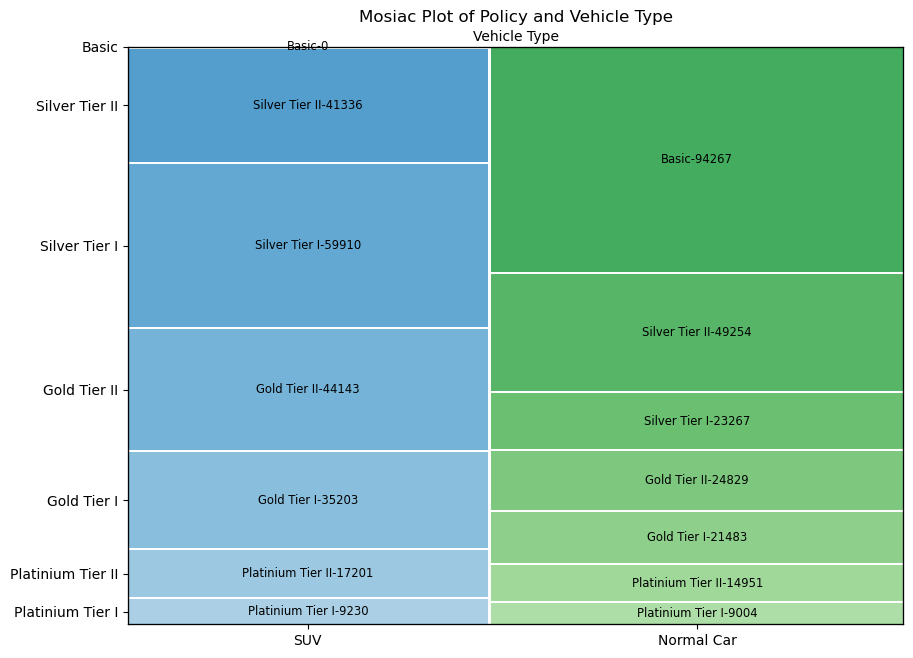

In [58]:
filtered_df = df[df["Vehicle_Type"].isin(["SUV","Normal Car"])]
filtered_df["Vehicle_Type"] = Categorical(filtered_df["Vehicle_Type"],["SUV","Normal Car"],ordered=True)

# Generate mosaic plot
with plt.rc_context({"figure.figsize":(10,7.5)}):
    plot_mosiac(filtered_df,'Vehicle_Type','Policy',cmap_list=["Blues","Greens"])
    
    # Customize the plot
    plt.xlabel("Vehicle Type")
    plt.ylabel("Policy")
    plt.title("Mosiac Plot of Policy and Vehicle Type")
    plt.show()
del(filtered_df)

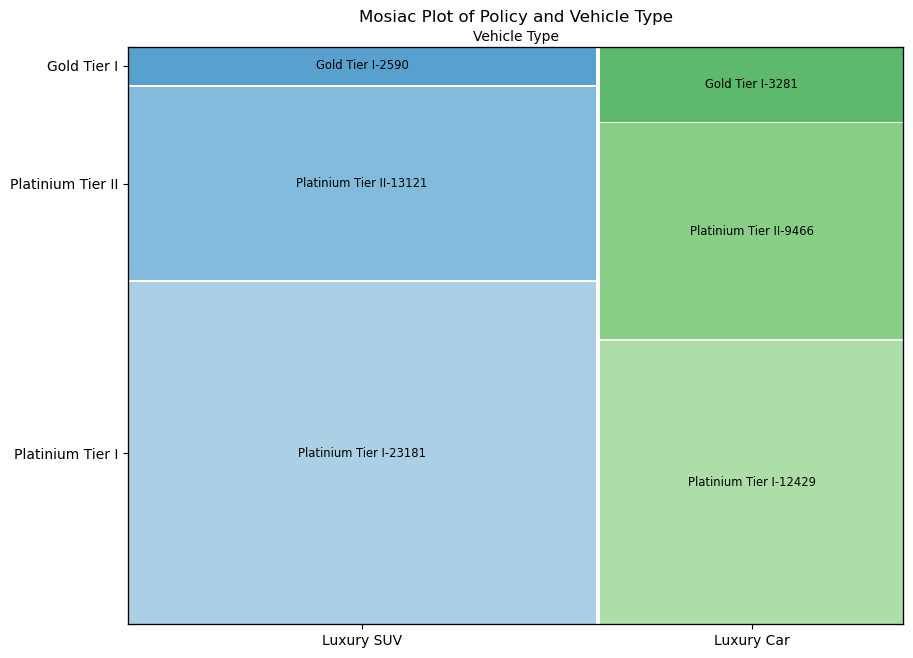

In [59]:
filtered_df = df[df["Vehicle_Type"].isin(["Luxury SUV","Luxury Car"])]
filtered_df["Vehicle_Type"] = Categorical(filtered_df["Vehicle_Type"],["Luxury SUV","Luxury Car"],ordered=True)
filtered_df["Policy"] = Categorical(filtered_df["Policy"],["Platinium Tier I","Platinium Tier II", "Gold Tier I"],ordered=True)

# Generate mosaic plot
with plt.rc_context({"figure.figsize":(10,7.5)}):
    plot_mosiac(filtered_df,'Vehicle_Type','Policy',cmap_list=["Blues","Greens"])
    
    # Customize the plot
    plt.xlabel("Vehicle Type")
    plt.ylabel("Policy")
    plt.title("Mosiac Plot of Policy and Vehicle Type")
    plt.show()

del(filtered_df)

In [60]:
detailed_crosstab(df,"Vehicle_Type","Policy")

<h4>Analysis</h4>
<p>Above analysis reveals distinct insurance tier preferences based on vehicle types:</p>
<ul>
<li><u>Basic Policy</u>: This budget-friendly option is understandably favored by owners of "Normal" cars (capturing around 40% of the market), likely due to the lower perceived risk and value of the vehicle. Also, Basic policy is only bought by customers with normal cars as the policy is not viable for other vehicle types.</li>
<li><u>Luxury Vehicles</u>:  A significant preference for premium coverage emerges for owners of luxury vehicles. This segment prioritizes comprehensive protection, reflected in the dominance of Platinum Tier I, Platinium Tier II, and Gold Tier I.</li>
<li><u>SUVs</u>: Gold and Silver Tier Policies are the most popular policies for our SUV-owning customers. The skew is especially prominent in Silver Tier I policy with 72.03% of Silver Tier I customers being SUV owners.</li>
</ul>

<h4>Marketing Suggestions</h4>
<ul>
<li><p><u>Targeted messaging</u>: Develop targeted marketing campaigns that speak directly to the concerns and priorities of each car owner segment. For "Normal" car owners, emphasize the value and affordability of the Basic policy. For luxury car owners, highlight the comprehensive protection and specialized features offered by the Platinum and Gold tiers. Especially promote the Gold Tier II policy which though being a premium policy has not gained traction in the Luxury Vehicle Segment.</p></li>
<li><p><u>Highlight benefits for luxury vehicles</u>: Ensure Platinum and Gold tier marketing materials clearly communicate the extended benefits and features that are particularly valuable for luxury car owners. This could include higher coverage limits, specialized repair services for luxury vehicles, or roadside assistance tailored to their needs. Especially try to promote Gold Tier II policies which seem to be lagging behind its contemporary policies.</p></li>
</ul>
<h4>Product Development Opportunities</h4>
<ul>
<li><p><u>Silver Tier I Product Development</u>: Silver Tier I has a high skew towards SUV customers though it should be affordable for Normal Car Owners as well. Try to analyze the features that are attractive for Normal Car owners and try to incorporate them into Silver Tier I policy or keep it as additional riders for Normal Car Owners.</p></li>
<li><p><u>Gold Tier II Product Development</u>: Gold Tier II policies should be customized to be more attractive to luxury car owners. Offer additional benefits like increased rental car coverage or theft protection.</p></li>
</ul>

<h3> Relation between Policy and whether the Vehicle has been previously Insured with our company </h3>

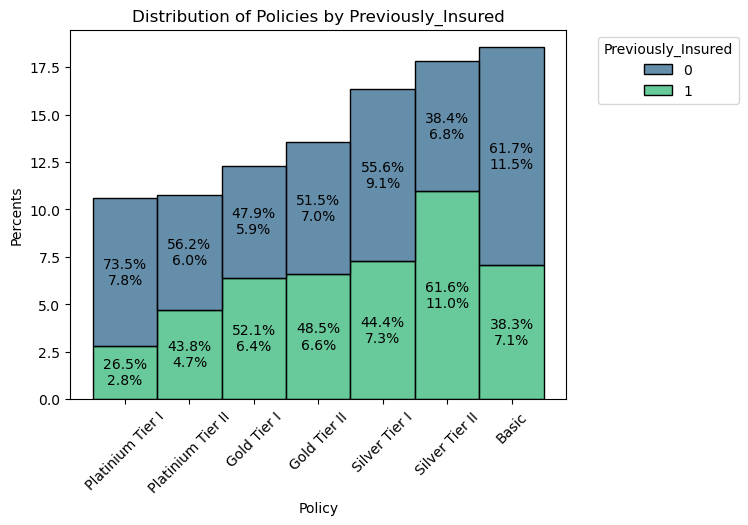

In [61]:
# Create the histogram
g=sns.histplot(x = "Policy",
               hue = "Previously_Insured",
               data = df,
               multiple = "stack",
               stat = "percent",
               palette = "viridis") 

# Calculating the percentages
percents = [[f"{level2[0]}%\n{level2[1]}%" for level2 in level1] for level1 in calculate_stack_percentages(df,"Policy","Previously_Insured")]
# Add percentage labels using bar_label with formatting
for i,container in enumerate(g.containers):
    g.bar_label(container, labels=percents[len(g.containers)-1-i],
                label_type='center')  # Adjust vertical alignment 

    
# Customize the plot
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1)) 
plt.xlabel("Policy")
plt.ylabel("Percents")
plt.title("Distribution of Policies by Previously_Insured")
plt.xticks(rotation=45)
plt.show()

del(g,percents)

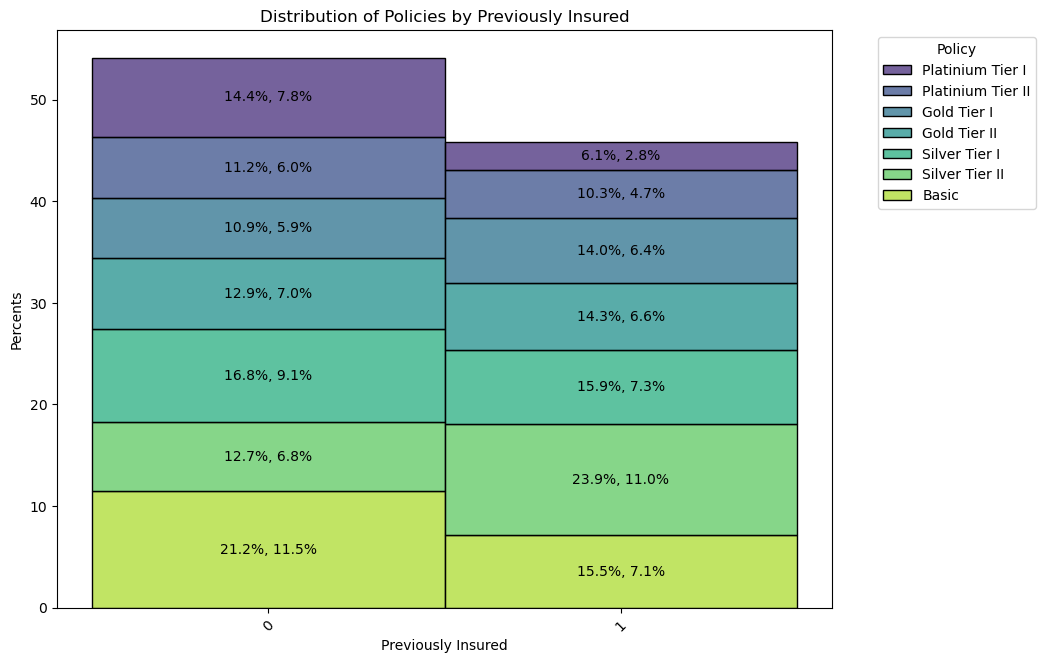

In [62]:
df0 = df.copy()
df0["Previously_Insured"]=df0["Previously_Insured"].astype(str)
# Create the histogram
plt.figure(figsize=(10, 7.5))
g=sns.histplot(x = "Previously_Insured",
               hue = "Policy",
               data = df0,
               multiple = "stack",
               stat = "percent",
               palette = "viridis",
               bins=[0.5,1.5])  

# Calculating the percentages

percents = [[f"{level2[0]}%, {level2[1]}%" for level2 in level1] for level1 in calculate_stack_percentages(df,"Previously_Insured","Policy")]
# Add percentage labels using bar_label with formatting
for i,container in enumerate(g.containers):
    g.bar_label(container, labels=percents[len(g.containers)-1-i],
                label_type='center')  # Adjust vertical alignment

    
# Customize the plot
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1)) 
plt.xlabel("Previously Insured")
plt.ylabel("Percents")
plt.title("Distribution of Policies by Previously Insured")
plt.xticks(rotation=45)

plt.show()
del(g,percents,df0)

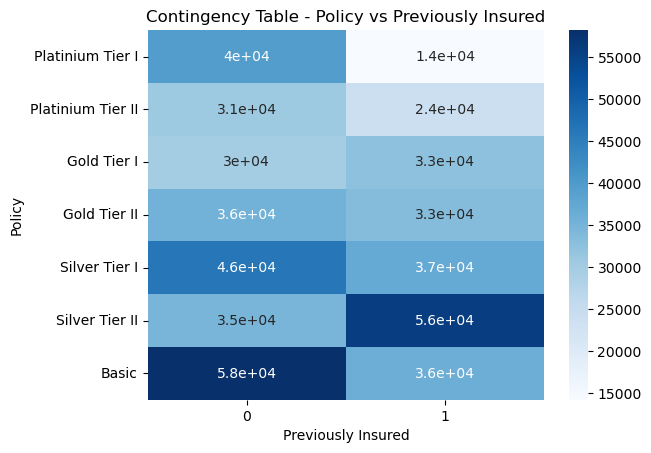

In [63]:
# Create a heatmap directly from the DataFrame
sns.heatmap(crosstab(df['Policy'], df['Previously_Insured']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Previously Insured')
plt.ylabel('Policy')
plt.title('Contingency Table - Policy vs Previously Insured')
plt.show()

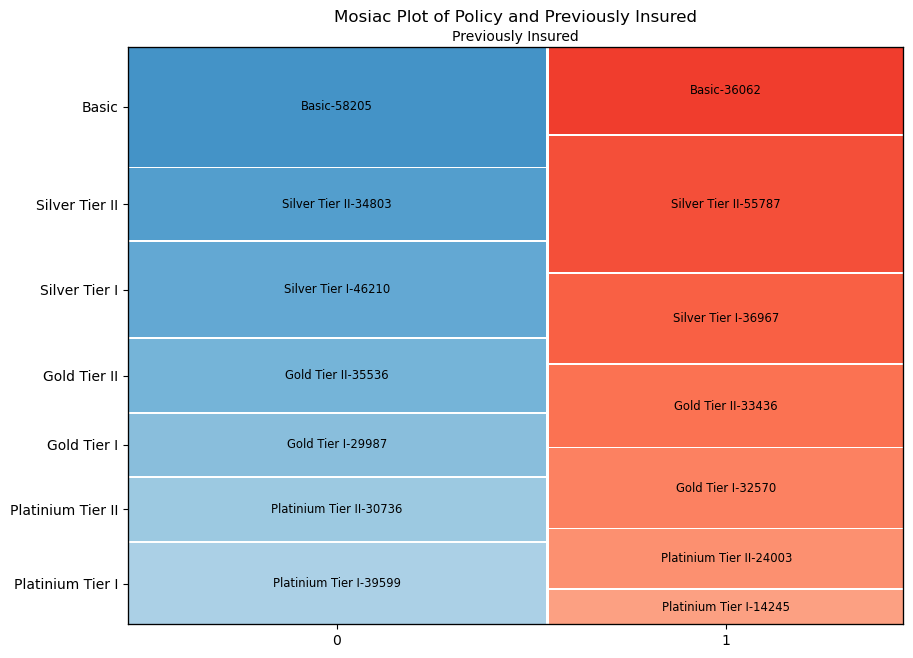

In [64]:
 # Generate mosaic plot
with plt.rc_context({"figure.figsize":(10,7.5)}):
    plot_mosiac(df,'Previously_Insured','Policy',cmap_list=["Blues","Reds"])
    
    # Customize the plot
    plt.xlabel("Previously Insured")
    plt.ylabel("Policy")
    plt.title("Mosiac Plot of Policy and Previously Insured")
    plt.show()

In [65]:
detailed_crosstab(df,"Previously_Insured","Policy")

<h4>Analysis</h4>
<p>The analysis is done along with Vehicle Damage as there seems to be high association among these features
</p>

<h3> Relation between Policy and Vehicle Age </h3>

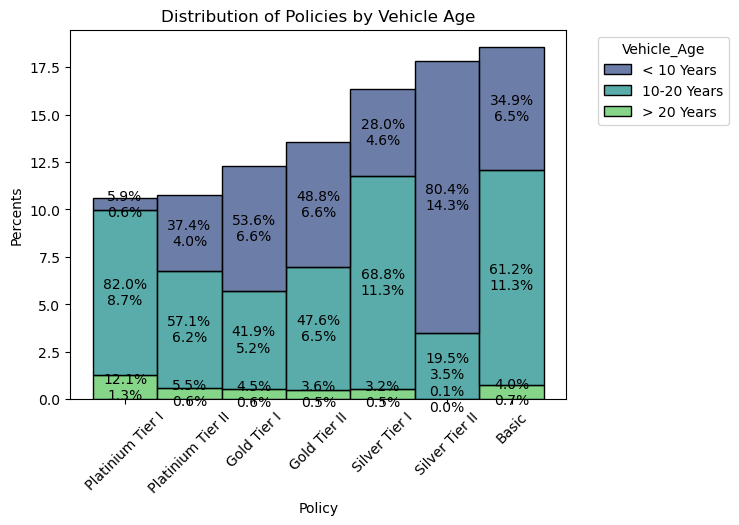

In [66]:
# Create the histogram
g=sns.histplot(x = "Policy",
               hue = "Vehicle_Age",
               data = df,
               multiple = "stack",
               stat = "percent",
               palette = "viridis") 

# Calculating the percentages
percents = [[f"{level2[0]}%\n{level2[1]}%" for level2 in level1] for level1 in calculate_stack_percentages(df,"Policy","Vehicle_Age")]
# Add percentage labels using bar_label with formatting
for i,container in enumerate(g.containers):
    g.bar_label(container, labels=percents[len(g.containers)-1-i],
                label_type='center')  # Adjust vertical alignment 

    
# Customize the plot
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1)) 
plt.xlabel("Policy")
plt.ylabel("Percents")
plt.title("Distribution of Policies by Vehicle Age")
plt.xticks(rotation=45)
plt.show()

del(g,percents)

As greater than 20 year old vehicles is a minority class, we will not analyze it further in further plots, as the bar chart is sufficient for its analysis.

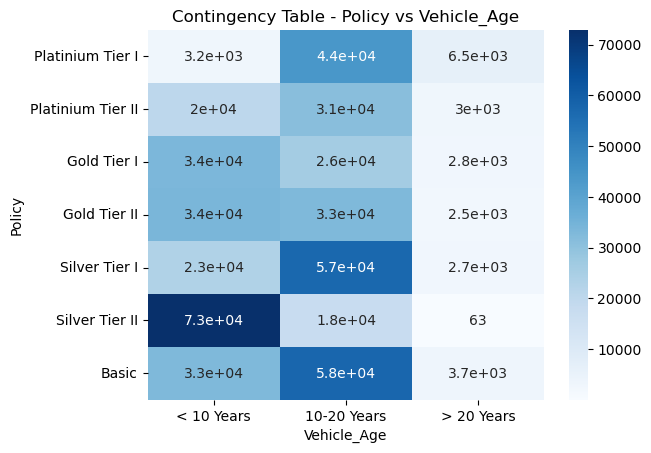

In [67]:
# Create a heatmap directly from the DataFrame
sns.heatmap(crosstab(df['Policy'], df['Vehicle_Age']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Vehicle_Age')
plt.ylabel('Policy')
plt.title('Contingency Table - Policy vs Vehicle_Age')
plt.show()

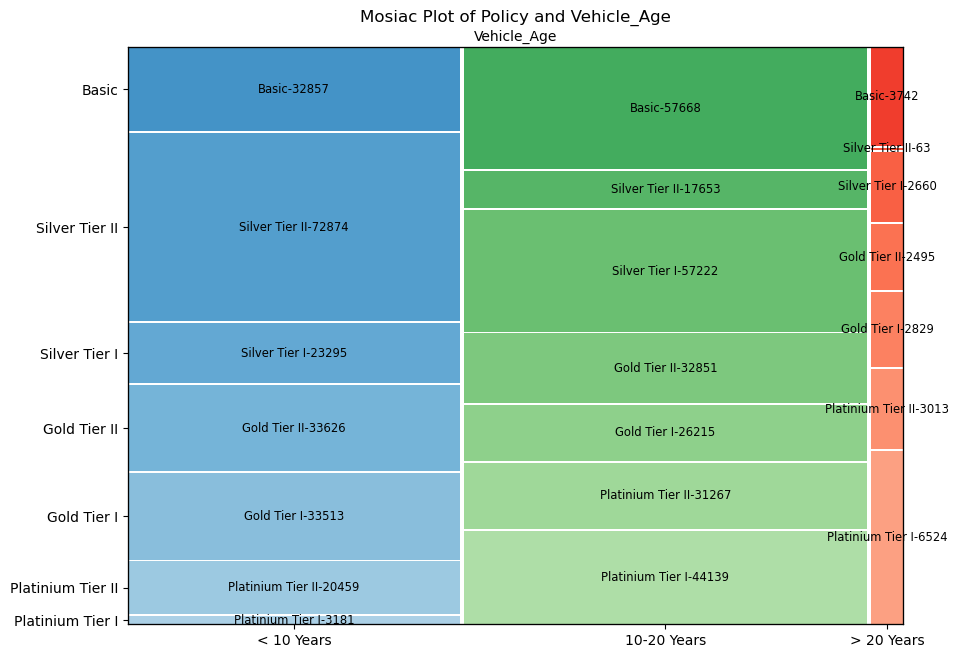

In [68]:
 # Generate mosaic plot
with plt.rc_context({"figure.figsize":(10,7.5)}):
    plot_mosiac(df,'Vehicle_Age','Policy',cmap_list=["Blues","Greens","Reds"])
    
    # Customize the plot
    plt.xlabel("Vehicle_Age")
    plt.ylabel("Policy")
    plt.title("Mosiac Plot of Policy and Vehicle_Age")
    plt.show()

In [69]:
detailed_crosstab(df,"Vehicle_Age","Policy")

<h4>Analysis</h4>
<ul>
<li><u>Vehicle Age Distributions</u>: Silver Tier II and Basic is overwhelmingly preferred for newer vehicles, whereas Platinium Tier I has most of its insured vehicles 10-20 years old. Around 30% of the market for vehicles older than 20 years is captured by the Platinium Tier I policy. Silver Tier II and Basic policies are slightly preferred for older vehicles.</li>
</ul>
<h4>Marketing Suggestions</h4>
<ul>
<li><p><u>Targeted messaging</u>: Develop targeted marketing campaigns that speak directly to the concerns and priorities of each vehicle age segment. For newer vehicles promote Silver Tier II and Basic which is the most popular for newer vehicles and for older premium vehicles promote Platinium Tier I and for non-premium vehicles promote Basic and Silver Tier II policies.</p></li>
</ul>
<h4>Product Development Opportunities</h4>
<ul>
<li><p><u>Silver Tier II  and Basic Feature Understanding</u>: Analyze with the support of the product team to understand the popularity of Silver Tier II and Basic among newer vehicles. Try to incorporate those features in our premium policies to attract owners of newer premium vehicles.</p></li>
</ul>

<h3> Relation between Policy and Vehicle Damage </h3>

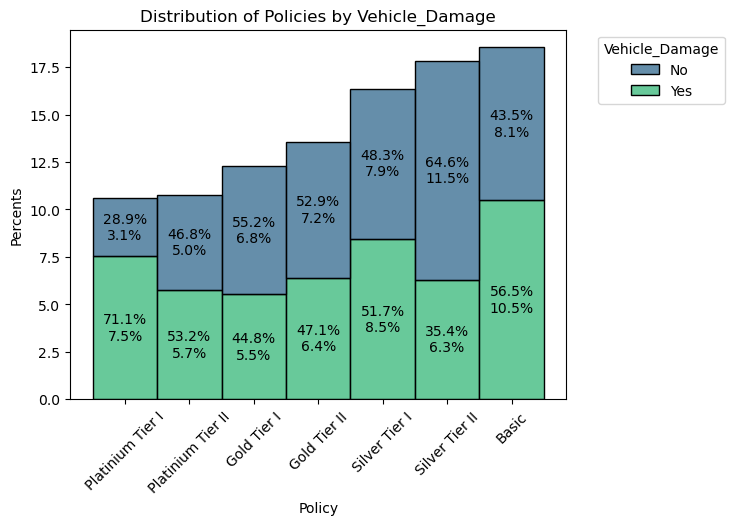

In [70]:
# Create the histogram
g=sns.histplot(x = "Policy",
               hue = "Vehicle_Damage",
               data = df,
               multiple = "stack",
               stat = "percent",
               palette = "viridis") 

# Calculating the percentages
percents = [[f"{level2[0]}%\n{level2[1]}%" for level2 in level1] for level1 in calculate_stack_percentages(df,"Policy","Vehicle_Damage")]
# Add percentage labels using bar_label with formatting
for i,container in enumerate(g.containers):
    g.bar_label(container, labels=percents[len(g.containers)-1-i],
                label_type='center')  # Adjust vertical alignment 

    
# Customize the plot
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1)) 
plt.xlabel("Policy")
plt.ylabel("Percents")
plt.title("Distribution of Policies by Vehicle_Damage")
plt.xticks(rotation=45)
plt.show()

del(g,percents)

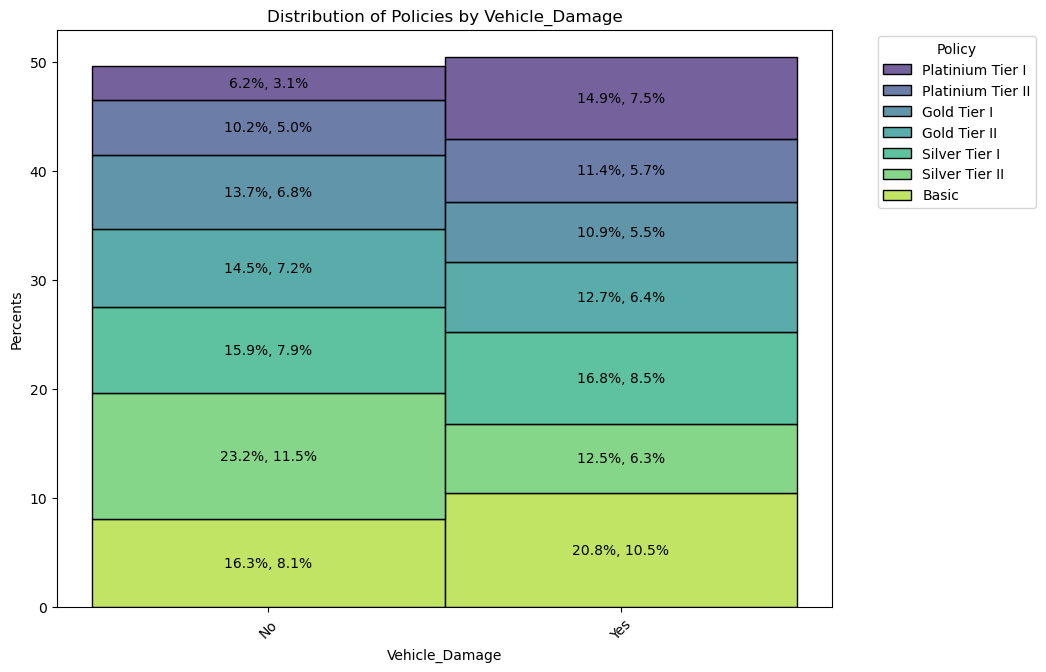

In [71]:
# Create the histogram
plt.figure(figsize=(10, 7.5))
g=sns.histplot(x = "Vehicle_Damage",
               hue = "Policy",
               data = df,
               multiple = "stack",
               stat = "percent",
               palette = "viridis")  

# Calculating the percentages

percents = [[f"{level2[0]}%, {level2[1]}%" for level2 in level1] for level1 in calculate_stack_percentages(df,"Vehicle_Damage","Policy")]
# Add percentage labels using bar_label with formatting
for i,container in enumerate(g.containers):
    g.bar_label(container, labels=percents[len(g.containers)-1-i],
                label_type='center')  # Adjust vertical alignment

    
# Customize the plot
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1)) 
plt.xlabel("Vehicle_Damage")
plt.ylabel("Percents")
plt.title("Distribution of Policies by Vehicle_Damage")
plt.xticks(rotation=45)

plt.show()
del(g,percents)

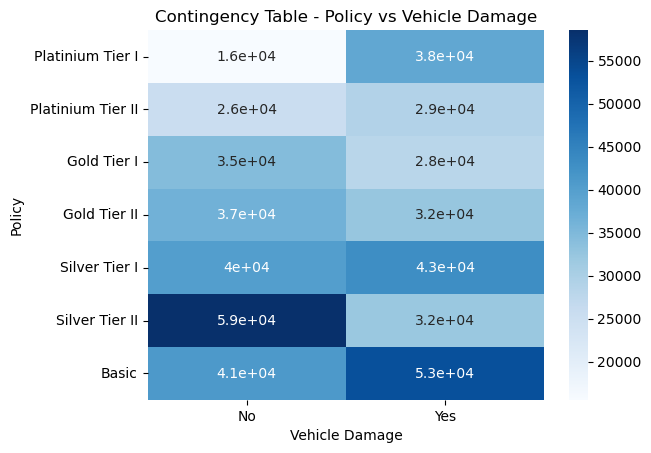

In [72]:
# Create a heatmap directly from the DataFrame
sns.heatmap(crosstab(df['Policy'], df['Vehicle_Damage']), cmap='Blues', annot=True)  # Adjust colormap as desired

# Customize the plot 
plt.xlabel('Vehicle Damage')
plt.ylabel('Policy')
plt.title('Contingency Table - Policy vs Vehicle Damage')
plt.show()

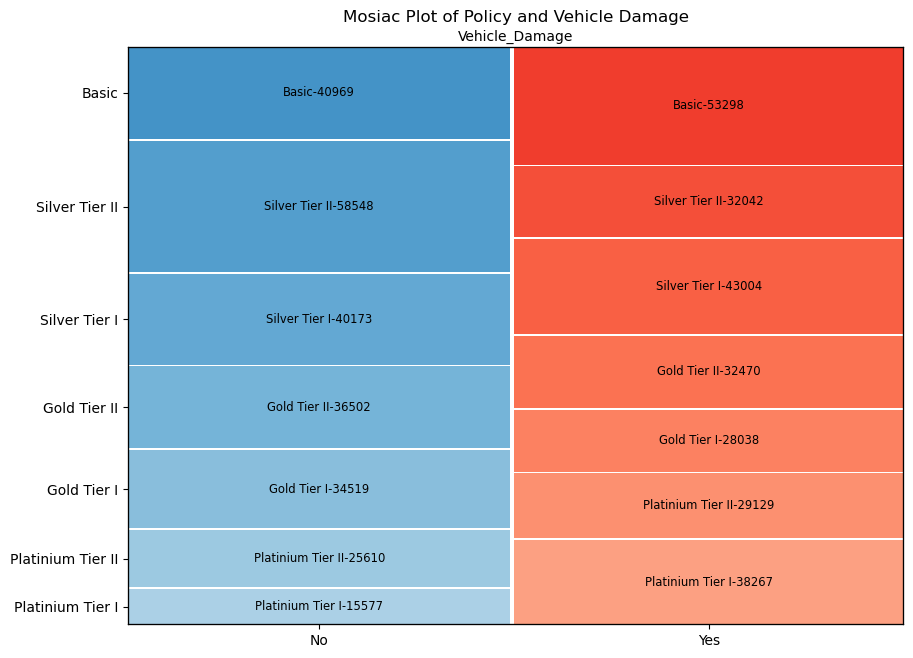

In [73]:
 # Generate mosaic plot
with plt.rc_context({"figure.figsize":(10,7.5)}):
    plot_mosiac(df,'Vehicle_Damage','Policy',cmap_list=["Blues","Reds"])
    
    # Customize the plot
    plt.xlabel("Vehicle_Damage")
    plt.ylabel("Policy")
    plt.title("Mosiac Plot of Policy and Vehicle Damage")
    plt.show()

In [74]:
detailed_crosstab(df,"Vehicle_Damage","Policy")

<h4>Analysis</h4>
<ul>
<li><u>Vehicle Damage Distributions</u>: Silver Tier II has most of the vehicles that have not been damaged. Similarly, Platinium Tier I has most of the vehicles insured with it having damages in the past. This is a bit intuitive as this premium policy has features that are beneficial for premium damaged vehicles.</li>
</ul>
<h4>Marketing Suggestions</h4>
<ul>
<li><p><u>Targeted messaging</u>: Develop marketing campaigns to show the beneficial features that Platinium Tier I has for damaged premium vehicles.</p></li>
</ul>
<h4>Product Development Opportunities</h4>
<ul>
<li><p><u>Platinium Tier I Feature Understanding</u>: Try to incorporate features of Platinium Tier I that are beneficial for damaged premium vehicles, into Platinium Tier II and Gold Tier policy to improve its premium vehicle market coverage.</p></li>
</ul>

<h4>Association Analysis</h4>

<p>The analysis of whether vehicles were previously insured with us and vehicle damage share a very similar trend. This is extremely interesting and needs to be analyzed further. To further understand this relation we plot the contingency table for the two variables</p>



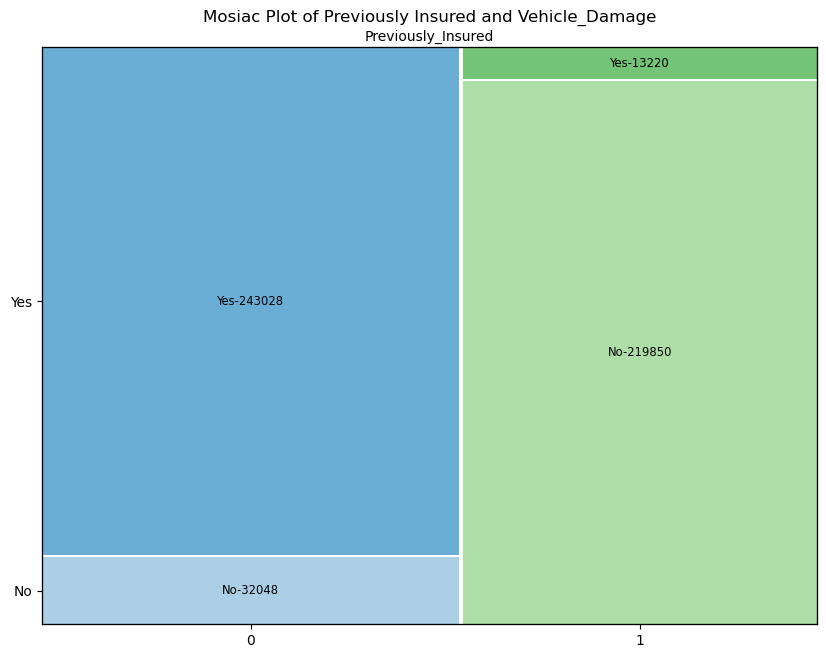

In [75]:
 # Generate mosaic plot
with plt.rc_context({"figure.figsize":(10,7.5)}):
    plot_mosiac(df,'Previously_Insured','Vehicle_Damage',cmap_list=["Blues","Greens"])
    
    # Customize the plot
    plt.xlabel("Previously_Insured")
    plt.ylabel("Vehicle_Damage")
    plt.title("Mosiac Plot of Previously Insured and Vehicle_Damage")
    plt.show()

In [76]:
detailed_crosstab(df,"Vehicle_Damage","Previously_Insured")

In [77]:
# Association Metrics

Metric_Dict = {
    "Accuracy": [np.round(len(df[((df["Vehicle_Damage"]=="Yes")&(df["Previously_Insured"]==0))|((df["Vehicle_Damage"]=="No")&(df["Previously_Insured"]==1))])
    /len(df),decimals=2)],
    "Support: P(Previously Insured and Not Damaged)": [np.round(len(df[(df["Vehicle_Damage"]=="No")&(df["Previously_Insured"]==1)])
    /len(df),decimals=2)],
    "ConfidenceType1: P(Previously Insured|Not Damaged)": [np.round(len(df[(df["Vehicle_Damage"]=="No")&(df["Previously_Insured"]==1)])
    /len(df[(df["Vehicle_Damage"]=="No")]),decimals=2)],
    "ConfidenceType2: P(Not Damaged|Previously Insured)": [np.round(len(df[(df["Vehicle_Damage"]=="No")&(df["Previously_Insured"]==1)])
    /len(df[(df["Previously_Insured"]==1)]),decimals=2)],
    "Lift: P(Previously Insured and Not Damaged)/(P(Not Damaged)*P(Previously Insured))": 
    [np.round((len(df[(df["Vehicle_Damage"]=="No")&(df["Previously_Insured"]==1)])*len(df))
    /(len(df[(df["Previously_Insured"]==1)])*len(df[(df["Vehicle_Damage"]=="No")])),decimals=2)],   
    "Leverage: P(Previously Insured and Not Damaged)-(P(Not Damaged)*P(Previously Insured))": 
    [np.round((len(df[(df["Vehicle_Damage"]=="No")&(df["Previously_Insured"]==1)])/len(df))
    -(len(df[(df["Previously_Insured"]==1)])/len(df)*len(df[(df["Vehicle_Damage"]=="No")])/len(df)),decimals=2)],
    "Support: P(Not Previously Insured and Damaged)": [np.round(len(df[(df["Vehicle_Damage"]=="Yes")&(df["Previously_Insured"]==0)])
    /len(df),decimals=2)],
    "ConfidenceType1: P(Not Previously Insured|Damaged)": [np.round(len(df[(df["Vehicle_Damage"]=="Yes")&(df["Previously_Insured"]==0)])
    /len(df[(df["Vehicle_Damage"]=="Yes")]),decimals=2)],
    "ConfidenceType2: P(Damaged|Not Previously Insured)": [np.round(len(df[(df["Vehicle_Damage"]=="Yes")&(df["Previously_Insured"]==0)])
    /len(df[(df["Previously_Insured"]==0)]),decimals=2)],
    "Lift: P(Not Previously Insured and Damaged)/(P(Damaged)*P(Not Previously Insured))": 
    [np.round((len(df[(df["Vehicle_Damage"]=="Yes")&(df["Previously_Insured"]==0)])*len(df))
    /(len(df[(df["Previously_Insured"]==0)])*len(df[(df["Vehicle_Damage"]=="Yes")])),decimals=2)],   
    "Leverage: P(Not Previously Insured and Damaged)-(P(Damaged)*P(Not Previously Insured))": 
    [np.round((len(df[(df["Vehicle_Damage"]=="Yes")&(df["Previously_Insured"]==0)])/len(df))
    -(len(df[(df["Previously_Insured"]==0)])/len(df)*len(df[(df["Vehicle_Damage"]=="Yes")])/len(df)),decimals=2)]    
}
Metric_df=DataFrame(Metric_Dict)
Metric_df=Metric_df.T
Metric_df=Metric_df.reset_index()
Metric_df.columns=["Metric","Measure"]
pretty_display(Metric_df)

In [78]:
# Contingency table
contingency_table = crosstab(df.sample(25,random_state=21)['Previously_Insured'], df.sample(25,random_state=21)['Vehicle_Damage'])

# Chi-square test
chi2, pval, degrees_of_freedom, expected_counts = chi2_contingency(contingency_table.values)

# Interpretation
print(f"With a p value of {pval} there is {'a' if pval < 0.05 else 'no'} statistically significant association between Previously_Insured and Vehicle_Damage.")



With a p value of 2.5006212712922025e-05 there is a statistically significant association between Previously_Insured and Vehicle_Damage.


<p>As per the above analysis there seems to be a strong association between previously insured with our company and vehicle damage. The association shows that most previously insured vehicles do not have damage and vehicles that were not previously insured with us have damage. This might be because previously insured vehicles the damage on the car was not repaired due to high repair charges not being covered by insurance. Similarly, not previously insured, the damage was repaired by the claim amount.</p>

<p>During Feature Engineering we will try to combine these two features (Previously_Insured and Vehicle_Damage) into a single feature using feature crossing.</p>

<h2> Feature Engineering </h2>

<h3>Feature Crossing</h3>

In [79]:
df["Location"] = df['Location_Type'].astype(str).str.cat(df['Region_Code'].astype(str), sep="-")
df["Vehicle_Status"] = df['Vehicle_Damage'].astype(str).str.cat(df['Previously_Insured'].astype(str), sep="-")
df=df[["id","Gender","Age","Region_Code","Location_Type","Location","Education","Annual_Income",
       "Vehicle_Type","Previously_Insured","Vehicle_Age","Vehicle_Damage","Vehicle_Status","Policy"]]
df['Location'] = Categorical(df['Location'],
                           ["Urban-NE", "Urban-W", "Urban-S", "Urban-MW", "Suburban-NE", "Suburban-W", "Suburban-S", "Suburban-MW",
                           "Rural-NE", "Rural-W", "Rural-S", "Rural-MW"],
                           ordered=True)
df['Vehicle_Status'] = Categorical(df['Vehicle_Status'],["No-0", "No-1", "Yes-0", "Yes-1"], ordered=True)
pretty_display(df.head())

<p>During data visualization we have realized two sets of features which can be merged into one feature.</p>
<ul>
    <li><p>The first set of features is Vehicle_Damage and Previously_Insured which have a high association./p></li>
    <li><p>The second set of features is Region_Code and Location_Type which both describe geographic location./p></li>
</ul>
<p>But before we proceed with engineering these features, we analyze the importance of these features using a simple Decision Tree Model.</p>

<h3>Feature Encoding</h3>


In [80]:
# Identifying the non-numeric columns
categorical_cols = [col for col in df.columns if (df[col].dtype not in ['int64', 'float64'] and col !="Policy")]

# Identifying the required order
order = [df.sort_values(col)[col].unique() for col in categorical_cols if col!="Policy"]

# Creating an encoded df
encoded_df = df.copy()

# Creating ordinal encoded object
encoder = OrdinalEncoder(categories=order)

if categorical_cols:
    encoded_df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

pretty_display(encoded_df.head())

del(order,categorical_cols)

<h3>Feature Standardization</h3>

In [81]:
# Creating StandardScaler object
scaler = StandardScaler()

# Converting int dtype columns into float before conversion
int_cols = [col for col in encoded_df.columns if (df[col].dtype == 'int64' and col not in ["id","Policy"])]

if int_cols:
    encoded_df[int_cols] = df[int_cols].astype("float64")

encoded_df.loc[:,~encoded_df.columns.isin(['id', 'Policy'])] = scaler.fit_transform(encoded_df.loc[:,~encoded_df.columns.isin(['id', 'Policy'])])
pretty_display(encoded_df.head())

del(int_cols)

<h3>Test-Validation-Train Split</h3>

In [82]:
X,y = encoded_df.loc[:,~encoded_df.columns.isin(['id', 'Policy'])], encoded_df["Policy"]

# Split data into training and testing sets (default test_size=0.3)
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.3, random_state=21)

# Split data into training and testing sets (default val_size=0.5)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=53)

<p>Testing without the newly created Location and  Vehicle_Status Field</p>

In [83]:
# Performing the classification
clf=DecisionTreeClassifier(max_depth = 7) # Starting with 7 as there are 7 classes
clf=clf.fit(X_train.loc[:,~X_train.columns.isin(['Location','Vehicle_Status'])],y_train)

In [84]:
# Applying the model to test data
y_pred = clf.predict(X_test.loc[:,~X_test.columns.isin(['Location','Vehicle_Status'])])

In [85]:
# Confusion Matrix

policy_order = sorted(list(y_test.unique()))
confusionMatrix = DataFrame(confusion_matrix(y_test, y_pred), columns = policy_order, index = policy_order)
policy_order = ["Platinium Tier I", "Platinium Tier II", "Gold Tier I", "Gold Tier II", "Silver Tier I", "Silver Tier II", "Basic"]
confusionMatrix = confusionMatrix.loc[policy_order,policy_order]
pretty_display(confusionMatrix)
del(policy_order)

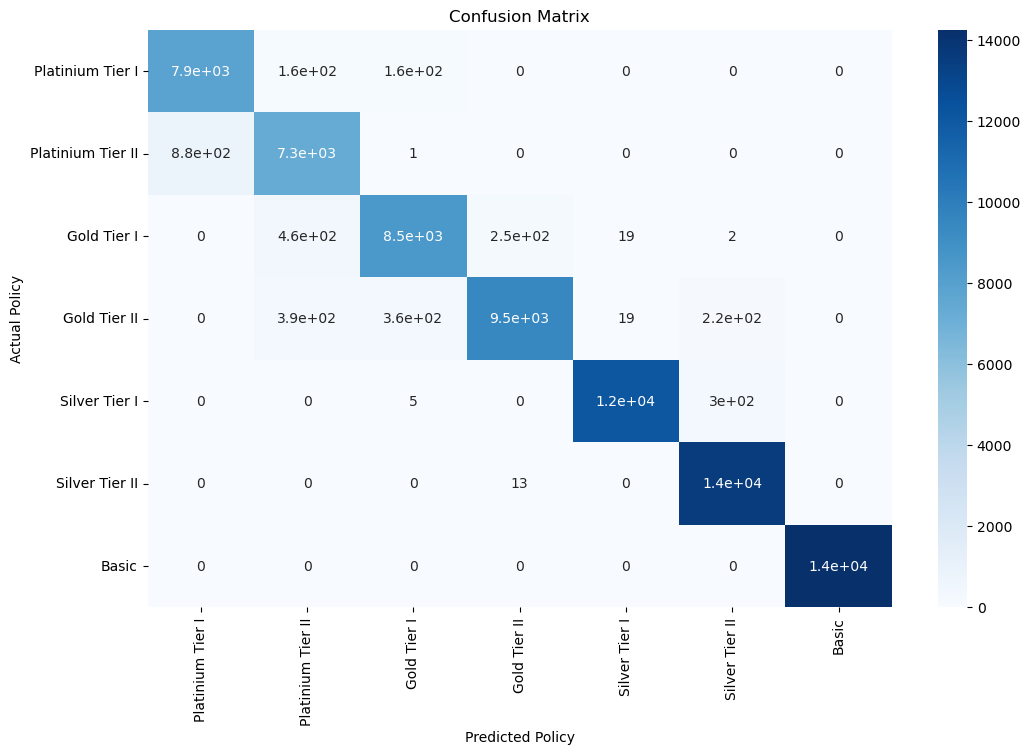

In [86]:
# Create a heatmap directly from the DataFrame
with plt.rc_context({"figure.figsize":(12,7.5)}):
    sns.heatmap(confusionMatrix, cmap='Blues', annot=True)  # Adjust colormap as desired
    
    # Customize the plot 
    plt.xlabel('Predicted Policy')
    plt.ylabel('Actual Policy')
    plt.title('Confusion Matrix')
    plt.show()

del(confusionMatrix)

In [87]:
# Get the classification report
report = classification_report(y_test, y_pred,output_dict=True)
# Print the classification report (includes decision matrix)
print("Classification Report:")
pretty_display(DataFrame(report).transpose(),format = "{:.5f}")

Classification Report:


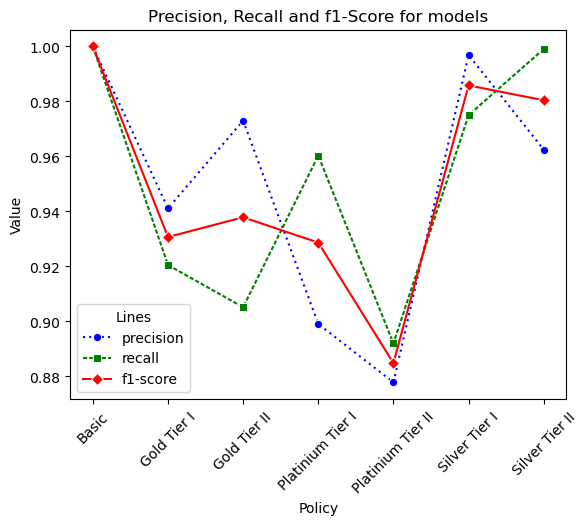

In [88]:
# Create the plot using sns.lineplot
report_df = DataFrame(report).transpose().drop("support",axis=1).drop(["accuracy",'macro avg','weighted avg'],axis=0).reset_index()
report_df = report_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], 
                  var_name='variable', value_name='value')

# Create lineplot with
sns.lineplot(data = report_df, 
             x = 'index', 
             y = 'value',
             hue='variable', 
             style='variable', 
             markers = ['o','s','D'],
             dashes = [(1,2),(2,1),''],
             palette = ["blue","green","red"])
            

# Customize the plot
plt.title("Precision, Recall and f1-Score for models")
plt.xlabel("Policy")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend(title="Lines")
plt.show()

del(report,report_df)

In [89]:
# Calculate various classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')

# For imbalanced classes or uncertain decision threshold
y_proba = clf.predict_proba(X_test.loc[:,~X_test.columns.isin(['Location', 'Vehicle_Status'])])
auc_ovr = roc_auc_score(y_test, y_proba, multi_class='ovr')
auc_ovo = roc_auc_score(y_test, y_proba, multi_class='ovo')

metrics = DataFrame({"Metric":["Accuracy", "Precision", "Recall", "f1","ROC-AUC-OVR","ROC-AUC-OVO"],
                     "Measure":[accuracy, precision, recall, f1,auc_ovr,auc_ovo]})

pretty_display(metrics, format = "{:.5f}")
del(metrics,accuracy,precision,recall,f1,auc_ovr,auc_ovo)

In [90]:
feature_importances = clf.feature_importances_
df_feature = DataFrame({"Feature": X_train.loc[:,~X_train.columns.isin(['Location', 'Vehicle_Status'])].columns,
                       "Feature Importance": feature_importances})
pretty_display(df_feature,format="{:.5f}")  # Shows importance scores for each feature
del(df_feature,feature_importances)

<p>Testing with the newly created Location and  Vehicle_Status Field</p>

In [91]:
# Performing the classification
clf=DecisionTreeClassifier(max_depth = 7)
clf=clf.fit(X_train.loc[:,~X_train.columns.isin(['Location_Type','Vehicle_Damage','Region_Code','Previously_Insured'])],y_train)

In [92]:
# Applying the model to test data
y_pred = clf.predict(X_test.loc[:,~X_test.columns.isin(['Location_Type','Vehicle_Damage','Region_Code','Previously_Insured'])])

In [93]:
# Confusion Matrix

policy_order = sorted(list(y_test.unique()))
confusionMatrix = DataFrame(confusion_matrix(y_test, y_pred), columns = policy_order, index = policy_order)
policy_order = ["Platinium Tier I", "Platinium Tier II", "Gold Tier I", "Gold Tier II", "Silver Tier I", "Silver Tier II", "Basic"]
confusionMatrix = confusionMatrix.loc[policy_order,policy_order]
pretty_display(confusionMatrix)
del(policy_order)

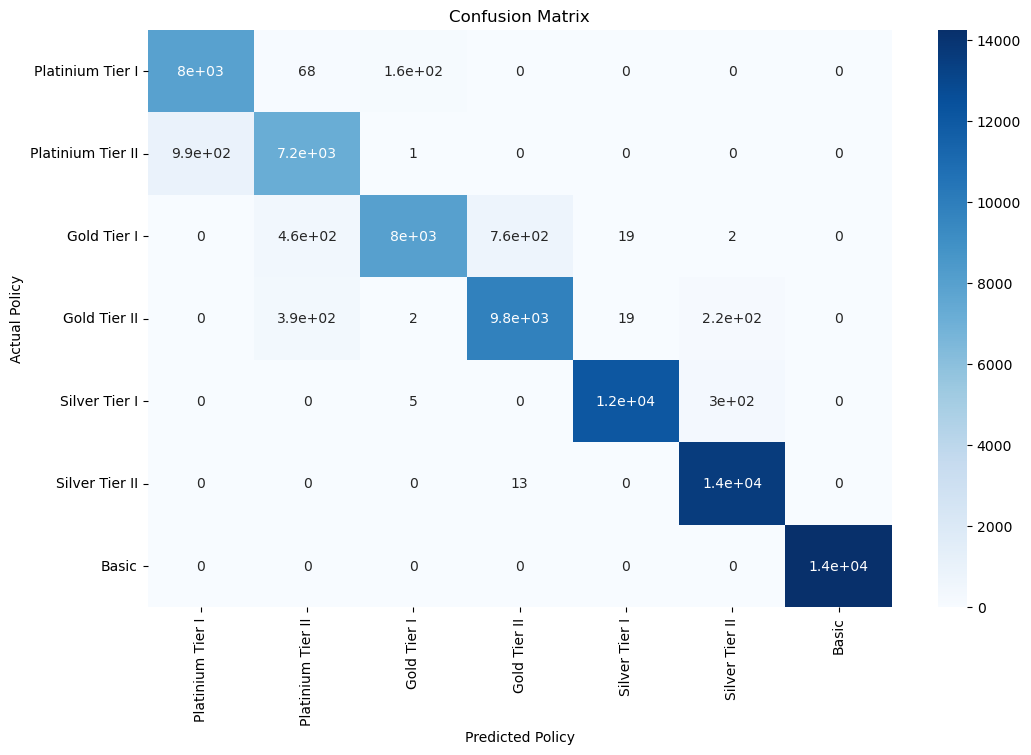

In [94]:
# Create a heatmap directly from the DataFrame
with plt.rc_context({"figure.figsize":(12,7.5)}):
    sns.heatmap(confusionMatrix, cmap='Blues', annot=True)  # Adjust colormap as desired
    
    # Customize the plot 
    plt.xlabel('Predicted Policy')
    plt.ylabel('Actual Policy')
    plt.title('Confusion Matrix')
    plt.show()

del(confusionMatrix)

In [95]:
# Get the classification report
report = classification_report(y_test, y_pred,output_dict=True)
# Print the classification report (includes decision matrix)
print("Classification Report:")
pretty_display(DataFrame(report).transpose(),format = "{:.5f}")

Classification Report:


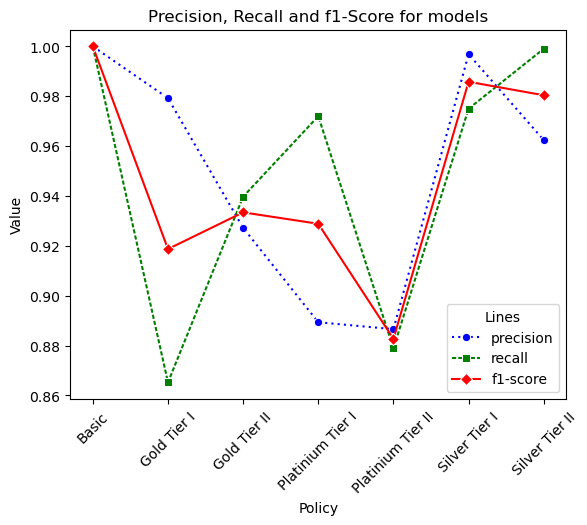

In [96]:
# Create the plot using sns.lineplot
report_df = DataFrame(report).transpose().drop("support",axis=1).drop(["accuracy",'macro avg','weighted avg'],axis=0).reset_index()
report_df = report_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], 
                  var_name='variable', value_name='value')

# Create lineplot with
sns.lineplot(data = report_df, 
             x = 'index', 
             y = 'value',
             hue='variable', 
             style='variable', 
             markers = ['o','s','D'],
             dashes = [(1,2),(2,1),''],
             palette = ["blue","green","red"])
            

# Customize the plot
plt.title("Precision, Recall and f1-Score for models")
plt.xlabel("Policy")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend(title="Lines")
plt.show()

del(report,report_df)

In [97]:
# Calculate various classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')

# For imbalanced classes or uncertain decision threshold
y_proba = clf.predict_proba(X_test.loc[:,~X_test.columns.isin(['Location_Type','Vehicle_Damage','Region_Code','Previously_Insured'])])
auc_ovr = roc_auc_score(y_test, y_proba, multi_class='ovr')
auc_ovo = roc_auc_score(y_test, y_proba, multi_class='ovo')

metrics = DataFrame({"Metric":["Accuracy", "Precision", "Recall", "f1","ROC-AUC-OVR","ROC-AUC-OVO"],
                     "Measure":[accuracy, precision, recall, f1,auc_ovr,auc_ovo]})

pretty_display(metrics, format = "{:.5f}")
del(metrics,accuracy,precision,recall,f1,auc_ovr,auc_ovo)

In [98]:
feature_importances = clf.feature_importances_
df_feature = DataFrame({"Feature": X_train.loc[:,~X_train.columns.isin(['Location_Type','Vehicle_Damage','Region_Code','Previously_Insured'])].columns,
                       "Feature Importance": feature_importances})
pretty_display(df_feature,format="{:.5f}")  # Shows importance scores for each feature
del(df_feature,feature_importances)

<p>As the feature importance of Location_Type, Region_Code, Vehicle_Damage and Previously_Insured is low and the accuracy of model with the original features and crossed features is the same we go ahead with crossed features to reduce the number of features from 10 to 8</p>

In [99]:
X_train.drop(["Location_Type","Region_Code","Previously_Insured","Vehicle_Damage"],axis = 1, inplace = True)
X_val.drop(["Location_Type","Region_Code","Previously_Insured","Vehicle_Damage"],axis = 1, inplace = True)
X_test.drop(["Location_Type","Region_Code","Previously_Insured","Vehicle_Damage"],axis = 1, inplace = True)

<h2>Modelling and Model Evaluation</h2>

<h3>Decision Trees</h3>

<p> Decision Trees are prone to overfitting and hence we will only increase the depth if we have a gain in accuracy of 0.0025.</p>

<h4> Optimizing Hyperparameters</h4>

In [247]:
accuracy_old = 0.95520 # Accuracy for max_depth = 7
for depth in range(8,15):
    # Performing the classification
    clf=DecisionTreeClassifier(max_depth = depth)
    clf=clf.fit(X_train,y_train)
    
    # Applying the model to test data
    y_pred = clf.predict(X_val)
    
    # Calculating the accuracy
    accuracy = accuracy_score(y_val, y_pred)

    if(accuracy - accuracy_old < 0.0025):
        break
    else:
        accuracy_old = accuracy

print(f"Optimal max depth for the model is {depth}")
print(f"The accuracy for the Optimal model on the validation data set is {accuracy:.5f}")

Optimal max depth for the model is 12
The accuracy for the Optimal model on the validation data set is 0.99849


<h3>Model Evaluation</h3>

In [248]:
# Applying the model to test data
y_pred_dtree = clf.predict(X_test)

In [249]:
# Confusion Matrix

policy_order = sorted(list(y_test.unique()))
confusionMatrix_dtree = DataFrame(confusion_matrix(y_test, y_pred_dtree), columns = policy_order, index = policy_order)
policy_order = ["Platinium Tier I", "Platinium Tier II", "Gold Tier I", "Gold Tier II", "Silver Tier I", "Silver Tier II", "Basic"]
confusionMatrix_dtree = confusionMatrix_dtree.loc[policy_order,policy_order]
pretty_display(confusionMatrix_dtree)
del(policy_order)

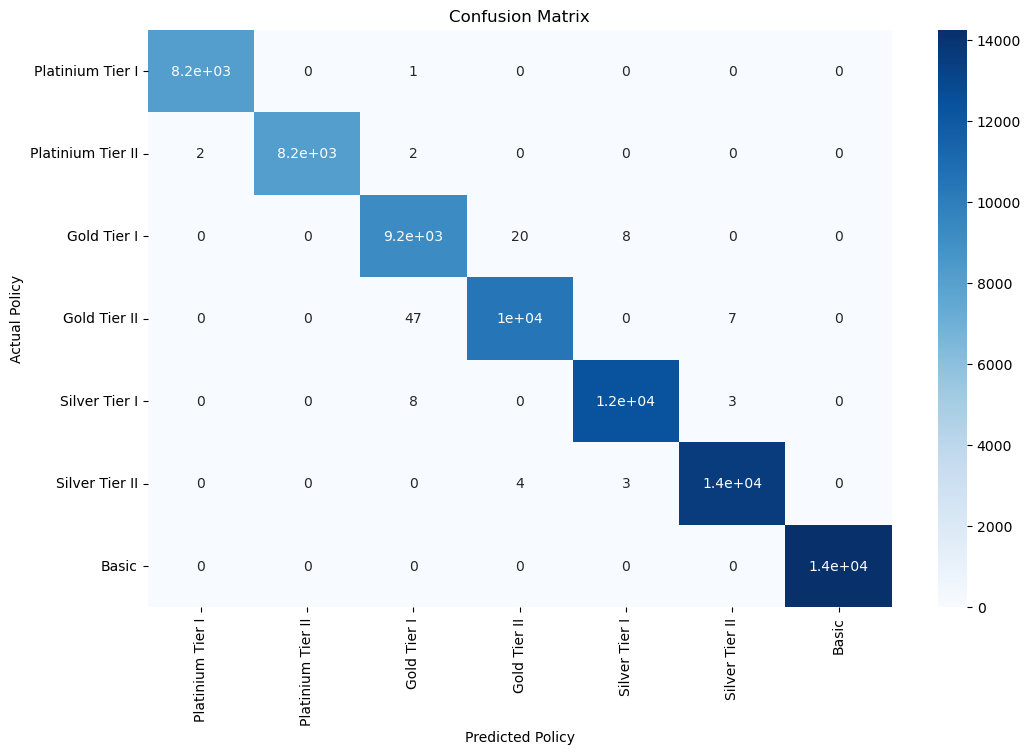

In [250]:
# Create a heatmap directly from the DataFrame
with plt.rc_context({"figure.figsize":(12,7.5)}):
    sns.heatmap(confusionMatrix_dtree, cmap='Blues', annot=True)  # Adjust colormap as desired
    
    # Customize the plot 
    plt.xlabel('Predicted Policy')
    plt.ylabel('Actual Policy')
    plt.title('Confusion Matrix')
    plt.show()

In [251]:
# Get the classification report
report_dtree = classification_report(y_test, y_pred_dtree,output_dict=True)
# Print the classification report (includes decision matrix)
print("Classification Report:")
pretty_display(DataFrame(report_dtree).transpose(),format = "{:.5f}")

Classification Report:


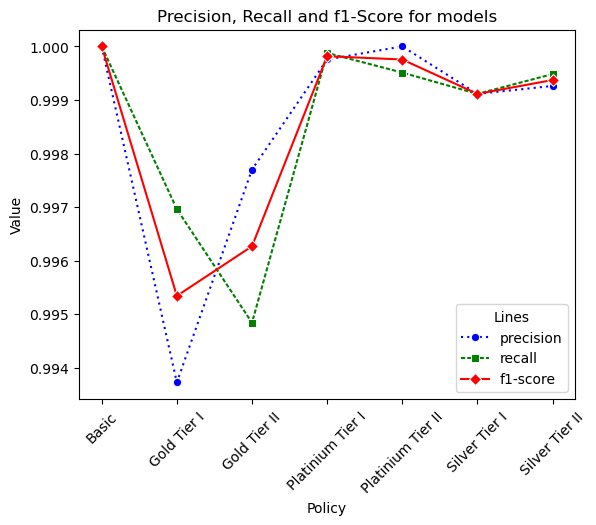

In [252]:
# Create the plot using sns.lineplot
report_dtree_df = DataFrame(report_dtree).transpose().drop("support",axis=1).drop(["accuracy",'macro avg','weighted avg'],axis=0).reset_index()
report_dtree_df = report_dtree_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], 
                  var_name='variable', value_name='value')

# Create lineplot with
sns.lineplot(data = report_dtree_df, 
             x = 'index', 
             y = 'value',
             hue='variable', 
             style='variable', 
             markers = ['o','s','D'],
             dashes = [(1,2),(2,1),''],
             palette = ["blue","green","red"])
            

# Customize the plot
plt.title("Precision, Recall and f1-Score for models")
plt.xlabel("Policy")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend(title="Lines")
plt.show()

In [257]:
# Calculate various classification metrics
accuracy_dt = accuracy_score(y_test, y_pred_dtree)
precision = precision_score(y_test, y_pred_dtree, average = 'weighted')
recall = recall_score(y_test, y_pred_dtree, average = 'weighted')
f1 = f1_score(y_test, y_pred_dtree, average = 'weighted')

# For imbalanced classes or uncertain decision threshold
y_proba = clf.predict_proba(X_test)
auc_ovr = roc_auc_score(y_test, y_proba, multi_class='ovr')
auc_ovo = roc_auc_score(y_test, y_proba, multi_class='ovo')

metrics = DataFrame({"Metric":["Accuracy", "Precision", "Recall", "f1","ROC-AUC-OVR","ROC-AUC-OVO"],
                     "Measure":[accuracy_dt, precision, recall, f1,auc_ovr,auc_ovo]})

pretty_display(metrics, format = "{:.5f}")
del(metrics,precision,recall,f1,auc_ovr,auc_ovo)

<h4> Feature Importance </h4>

In [258]:
feature_importances = clf.feature_importances_
df_feature = DataFrame({"Feature": X_train.columns,
                       "Feature Importance": feature_importances})
pretty_display(df_feature,format="{:.5f}")  # Shows importance scores for each feature
del(df_feature,feature_importances)

<h3>Random Forest</h3>

<h4> Optimizing Hyperparameters </h4>

In [259]:
# Check if the model is already has been run, if yes take the value from the json
if exists('rf_results.json'):
        with open('rf_results.json', 'r') as json_file:
                results = load(json_file)
                optimal_params = results['optimal_params']
                optimal_accuracy = results['optimal_accuracy']
                print(f'Best parameters: {optimal_params}')
                print(f'Best cross-validation accuracy: {optimal_accuracy:.5f}')
else:
    # Define the parameter grid
    param_grid = {
        'n_estimators': [50,100,150,200,250],
    }
    
    rf = RandomForestClassifier(random_state = 786)
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1,verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and cross-validation accuracy
    print(f'Best parameters: {(optimal_params:= grid_search.best_params_)}')
    print(f'Best cross-validation accuracy: {(optimal_accuracy:= grid_search.best_score_):.5f}')

    # Writing it in json file
    results = {'optimal_params': optimal_params, 'optimal_accuracy': optimal_accuracy}
    with open('rf_results.json', 'w') as json_file:
        dump(results, json_file)

Best parameters: {'n_estimators': 250}
Best cross-validation accuracy: 0.99727


In [260]:
rf = RandomForestClassifier(random_state = 786,**optimal_params)
rf = rf.fit(X_train,y_train)

<h4>Model Evaluation</h4>

In [261]:
y_pred_rf = rf.predict(X_test)

In [262]:
# Confusion Matrix

policy_order = sorted(list(y_test.unique()))
confusionMatrix_rf = DataFrame(confusion_matrix(y_test, y_pred_rf), columns = policy_order, index = policy_order)
policy_order = ["Platinium Tier I", "Platinium Tier II", "Gold Tier I", "Gold Tier II", "Silver Tier I", "Silver Tier II", "Basic"]
confusionMatrix_rf = confusionMatrix_rf.loc[policy_order,policy_order]
pretty_display(confusionMatrix_rf)
del(policy_order)

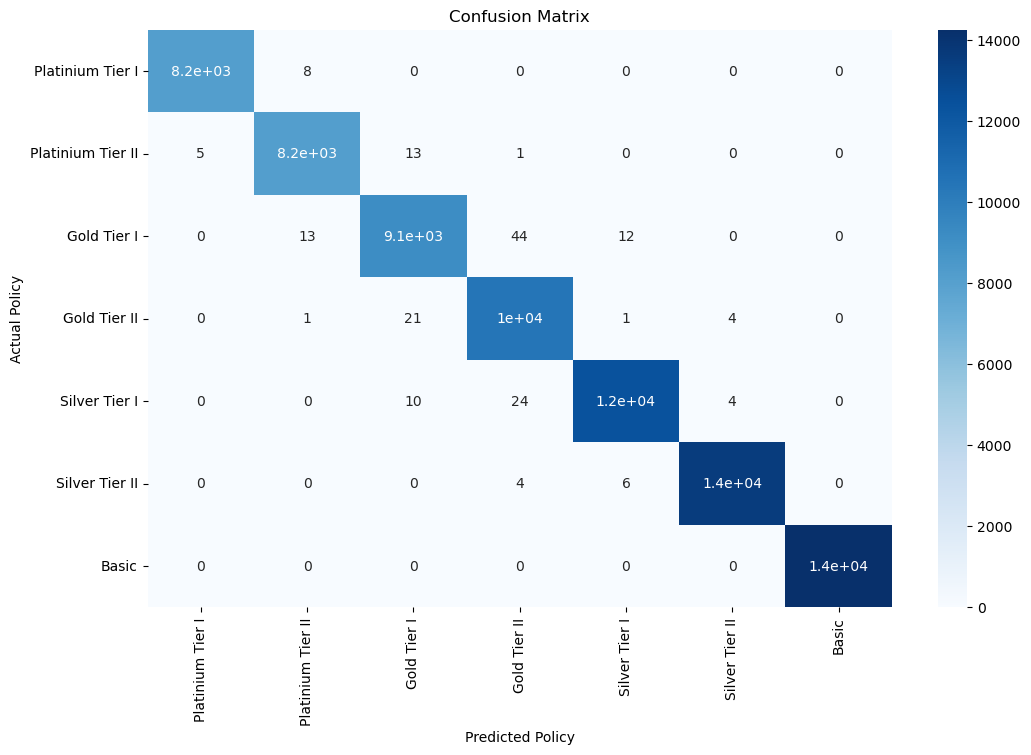

In [263]:
# Create a heatmap directly from the DataFrame
with plt.rc_context({"figure.figsize":(12,7.5)}):
    sns.heatmap(confusionMatrix_rf, cmap='Blues', annot=True)  # Adjust colormap as desired
    
    # Customize the plot 
    plt.xlabel('Predicted Policy')
    plt.ylabel('Actual Policy')
    plt.title('Confusion Matrix')
    plt.show()

In [264]:
# Get the classification report
report_rf = classification_report(y_test, y_pred_rf,output_dict=True)
# Print the classification report (includes decision matrix)
print("Classification Report:")
pretty_display(DataFrame(report_rf).transpose(),format = "{:.5f}")

Classification Report:


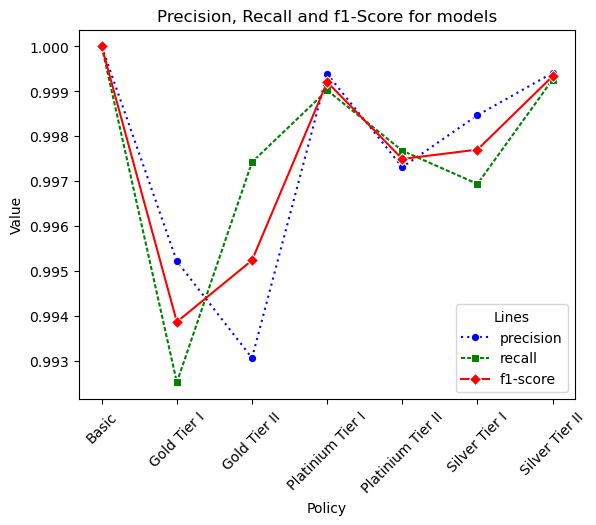

In [265]:
# Create the plot using sns.lineplot
report_rf_df = DataFrame(report_rf).transpose().drop("support",axis=1).drop(["accuracy",'macro avg','weighted avg'],axis=0).reset_index()
report_rf_df = report_rf_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], 
                  var_name='variable', value_name='value')

# Create lineplot with
sns.lineplot(data = report_rf_df, 
             x = 'index', 
             y = 'value',
             hue='variable', 
             style='variable', 
             markers = ['o','s','D'],
             dashes = [(1,2),(2,1),''],
             palette = ["blue","green","red"])
            

# Customize the plot
plt.title("Precision, Recall and f1-Score for models")
plt.xlabel("Policy")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend(title="Lines")
plt.show()

In [267]:
# Calculate various classification metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average = 'weighted')
recall = recall_score(y_test, y_pred_rf, average = 'weighted')
f1 = f1_score(y_test, y_pred_rf, average = 'weighted')

# For imbalanced classes or uncertain decision threshold
y_proba = rf.predict_proba(X_test)
auc_ovr = roc_auc_score(y_test, y_proba, multi_class='ovr')
auc_ovo = roc_auc_score(y_test, y_proba, multi_class='ovo')

metrics = DataFrame({"Metric":["Accuracy", "Precision", "Recall", "f1","ROC-AUC-OVR","ROC-AUC-OVO"],
                     "Measure":[accuracy_rf, precision, recall, f1,auc_ovr,auc_ovo]})

pretty_display(metrics, format = "{:.5f}")
del(metrics,precision,recall,f1,auc_ovr,auc_ovo)

<h4>Feature Importance </h4>

In [268]:
feature_importances = rf.feature_importances_
df_feature = DataFrame({"Feature": X_train.columns,
                       "Feature Importance": feature_importances})
pretty_display(df_feature,format="{:.5f}")  # Shows importance scores for each feature
del(df_feature,feature_importances)

<h3> AdaBoost </h3>

In [269]:
ada = AdaBoostClassifier(random_state=786,learning_rate = 0.1)
ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.1, random_state=786)

In [270]:
y_pred_ada = ada.predict(X_test)

In [272]:
accuracy_ada = accuracy_score(y_test, y_pred_ada)

In [273]:
print(accuracy_ada)

0.43731468604864737


<p>Since Adaboost cannot provide high accuracy for this dataset we abandon the model. Adaboost depends on weak learners and for data that has simple patterns and not many misclassifications in decision trees, random forest is a better ensemble model than AdaBoost which was observed in this case.</p>

<h3> XGBoost </h3>

<h4>Optimizing Hyperparameter </h4>

In [274]:
# We are using the train method for xgboost and will be using lgbClassifier for Light Gradient Boost for practice purpose.

y_train_float = y_train.copy()
y_test_float = y_test.copy()
y_val_float = y_val.copy()

# Creating ordinal encoded object
y_encoder = OrdinalEncoder(categories = [["Platinium Tier I", "Platinium Tier II", 
                                          "Gold Tier I", "Gold Tier II", "Silver Tier I", "Silver Tier II", "Basic"]])

y_train_float = y_train_float.values.reshape(-1,1)
y_test_float = y_test_float.values.reshape(-1, 1)
y_val_float = y_val_float.values.reshape(-1, 1)

y_train_float = y_encoder.fit_transform(y_train_float)
y_test_float = y_encoder.fit_transform(y_test_float)
y_val_float = y_encoder.fit_transform(y_val_float)

y_train_float = DataFrame(y_train_float, columns = ["Policy"])
y_test_float = DataFrame(y_test_float, columns = ["Policy"])
y_val_float = DataFrame(y_val_float, columns = ["Policy"])

# Create DMatrix for training data
d_train = xgb.DMatrix(X_train, label=y_train_float)
d_val = xgb.DMatrix(X_val, label=y_val_float) 
d_test = xgb.DMatrix(X_test, label=y_test_float) 


In [275]:
# Define hyperparameters
params = {
    'max_depth': 0,
    'eta': 0,
    'objective': 'multi:softmax',  # Multi-class classification objective
    'num_class': 7,  # Number of classes in your classification task
    'silent': True,   # Suppress verbose output during training
    'eval_metric': 'mlogloss', # Evaluation_metric
    'n_estimators': 100,
    'alpha': 0.25,
    'lambda': 2.1,
    'subsample': 0.7,
    'gamma':0.7,
    'seed':786,
    'verbosity': 0,
    'nthread': -1  # Use all available CPU cores
}

# Check if the model is already has been run, if yes take the value from the json
if exists('xgb_results.json'):
        with open('xgb_results.json', 'r') as json_file:
                results = load(json_file)
                optimal_depth = results['optimal_depth']
                optimal_eta = results['optimal_accuracy']
                optimal_accuracy = results['optimal_accuracy']
                print(f'Optimal depth: {(optimal_depth)}')
                print(f'Optimal eta: {(optimal_eta)}')
                print(f'Best accuracy: {(optimal_accuracy):.5f}')
            
else:


    
    xgb_dict = {
        'depth': [],
        'eta': [],
        'accuracy': []
    }
    
    for depth in range(5,12):
        for eta in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]:
    
            params['max_depth'] = int(depth)
            params['eta'] = eta

            # Running the model
            xgb_model = xgb.train(params,d_train, evals=[(d_train, 'train'), (d_val, 'val')],
                                  verbose_eval=False, early_stopping_rounds = 10, num_boost_round = 100)
            y_pred_xgb = xgb_model.predict(d_test)
            accuracy = accuracy_score(y_test_float, y_pred_xgb)

            # Appending the depth, eta and accuracy to xgb_dict for the current model
            xgb_dict['depth'].append(depth)
            xgb_dict['eta'].append(eta)
            xgb_dict['accuracy'].append(accuracy)

    # Converting xgb_dict to Dataframe and finding the params for highest accuracy               
    xgb_df = DataFrame(xgb_dict)
    max_row = xgb_df.loc[xgb_df['accuracy'].idxmax()]
 
    # Print the best parameters and cross-validation accuracy
    print(f'Optimal depth: {(optimal_depth:= max_row["depth"])}')
    print(f'Optimal eta: {(optimal_eta:= max_row["eta"])}')
    print(f'Best accuracy: {(optimal_accuracy:= max_row["accuracy"]):.5f}')

    # Writing it in json file
    results = {'optimal_depth': optimal_depth, 'optimal_eta': optimal_eta, 'optimal_accuracy': optimal_accuracy}
    with open('xgb_results.json', 'w') as json_file:
        dump(results, json_file)

Optimal depth: 9.0
Optimal eta: 0.9917477893521556
Best accuracy: 0.99175


In [276]:
# Getting the best params
params['max_depth'] = int(optimal_depth)
params['eta'] = optimal_eta

In [277]:
xgb_model = xgb.train(params,d_train, evals=[(d_train, 'train'), (d_val, 'val')], verbose_eval=False, early_stopping_rounds = 10, num_boost_round = 100)

In [278]:
y_pred_xgb = xgb_model.predict(d_test)

In [279]:
# Confusion Matrix

policy_order = ["Platinium Tier I", "Platinium Tier II", "Gold Tier I", "Gold Tier II", "Silver Tier I", "Silver Tier II", "Basic"]
confusionMatrix_xgb = DataFrame(confusion_matrix(y_test_float, y_pred_xgb), columns = policy_order, index = policy_order)
confusionMatrix_xgb = confusionMatrix_xgb.loc[policy_order,policy_order]
pretty_display(confusionMatrix_xgb)
del(policy_order)

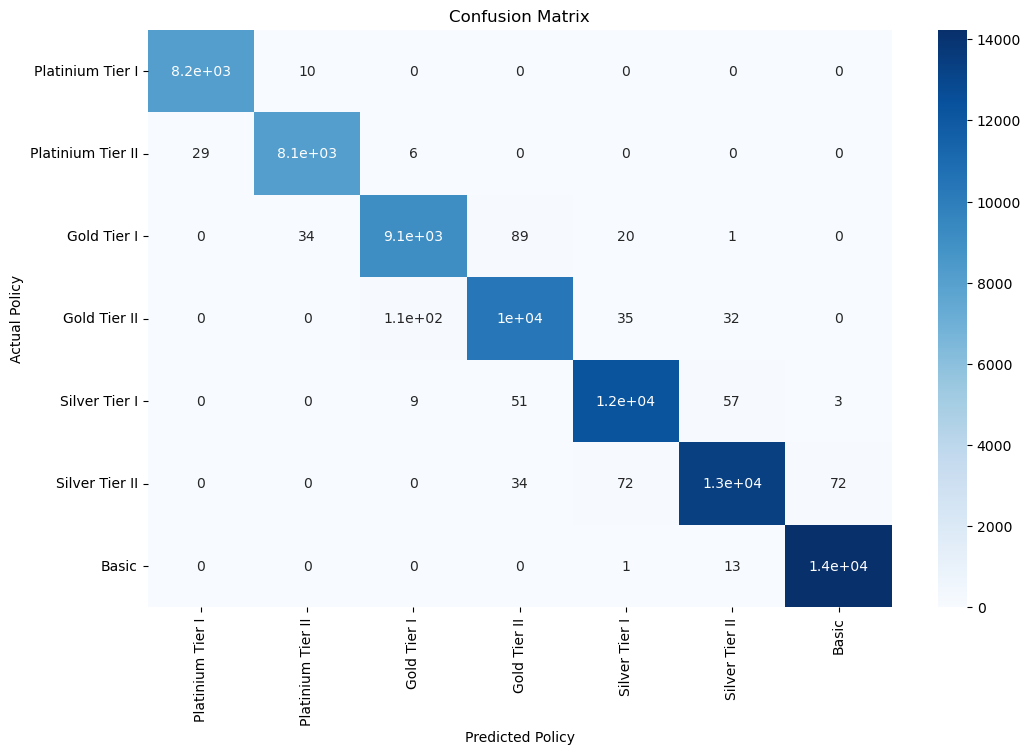

In [280]:
# Create a heatmap directly from the DataFrame
with plt.rc_context({"figure.figsize":(12,7.5)}):
    sns.heatmap(confusionMatrix_xgb, cmap='Blues', annot=True)  # Adjust colormap as desired
    
    # Customize the plot 
    plt.xlabel('Predicted Policy')
    plt.ylabel('Actual Policy')
    plt.title('Confusion Matrix')
    plt.show()

In [281]:
# Get the classification report
y_pred_xgb_decoded = y_encoder.inverse_transform(y_pred_xgb.reshape(-1,1))
report_xgb = classification_report(y_test, y_pred_xgb_decoded,output_dict=True)
# Print the classification report (includes decision matrix)
print("Classification Report:")
pretty_display(DataFrame(report_xgb).transpose(),format = "{:.5f}")

Classification Report:


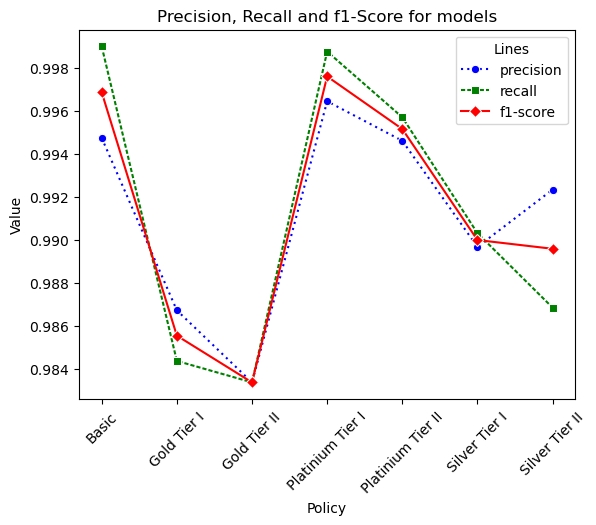

In [282]:
# Create the plot using sns.lineplot
report_xgb_df = DataFrame(report_xgb).transpose().drop("support",axis=1).drop(["accuracy",'macro avg','weighted avg'],axis=0).reset_index()
report_xgb_df = report_xgb_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], 
                  var_name='variable', value_name='value')

# Create lineplot with
sns.lineplot(data = report_xgb_df, 
             x = 'index', 
             y = 'value',
             hue='variable', 
             style='variable', 
             markers = ['o','s','D'],
             dashes = [(1,2),(2,1),''],
             palette = ["blue","green","red"])
            

# Customize the plot
plt.title("Precision, Recall and f1-Score for models")
plt.xlabel("Policy")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend(title="Lines")
plt.show()

In [284]:
# Calculate various classification metrics
accuracy_xgb = accuracy_score(y_test_float, y_pred_xgb)
precision = precision_score(y_test_float, y_pred_xgb, average = 'weighted')
recall = recall_score(y_test_float, y_pred_xgb, average = 'weighted')
f1 = f1_score(y_test_float, y_pred_xgb, average = 'weighted')


metrics = DataFrame({"Metric":["Accuracy", "Precision", "Recall", "f1"],
                     "Measure":[accuracy_xgb, precision, recall, f1]})

pretty_display(metrics, format = "{:.5f}")
del(metrics,precision,recall,f1)

<h3> LightGBM </h3>

In [285]:
df_bgm = df.drop(["id","Location_Type","Region_Code","Vehicle_Damage","Previously_Insured"], axis=1)
categorical_cols = [col for col in df_bgm.columns if (df_bgm[col].dtype not in ['int64', 'float64'] and col != "Policy")]
scaler_bgm = StandardScaler()
df_bgm[["Age","Annual_Income"]] = scaler_bgm.fit_transform(df_bgm[["Age","Annual_Income"]])
df_bgm["Policy"] = y_encoder.fit_transform(np.array(df_bgm["Policy"]).reshape(-1,1))

X_bgm,y_bgm = df_bgm.drop("Policy",axis=1), df_bgm["Policy"]

# Split data into training and testing sets (default test_size=0.3)
X_train_bgm, X_testval_bgm, y_train_bgm, y_testval_bgm = train_test_split(X_bgm, y_bgm, test_size=0.3, random_state=21)

# Split data into training and testing sets (default val_size=0.5)
X_val_bgm, X_test_bgm, y_val_bgm, y_test_bgm, = train_test_split(X_testval_bgm, y_testval_bgm, test_size=0.5, random_state=53)





In [286]:
# Check if the model is already has been run, if yes take the value from the json
if exists('lgb_results.json'):
        with open('lgb_results.json', 'r') as json_file:
                results = load(json_file)
                optimal_params = results['optimal_params']
                optimal_accuracy = results['optimal_accuracy']
                print(f'Best parameters: {optimal_params}')
                print(f'Best cross-validation accuracy: {optimal_accuracy:.5f}')
            
else:
    param_grid = {
        'num_leaves': [31, 63],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
        'max_depth': [-1, 5, 10],
    }
    
    lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=7)
    grid_search = GridSearchCV(lgb_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_bgm, y_train_bgm)
    
    # Print the best parameters and cross-validation accuracy
    print(f'Best parameters: {(optimal_params:= grid_search.best_params_)}')
    print(f'Best cross-validation accuracy: {(optimal_accuracy:= grid_search.best_score_):.5f}')

    # Writing it in json file
    results = {'optimal_params': optimal_params, 'optimal_accuracy': optimal_accuracy}
    with open('lgb_results.json', 'w') as json_file:
        dump(results, json_file)

Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 63}
Best cross-validation accuracy: 0.99269


In [287]:
best_params = optimal_params
lgb_model = lgb.LGBMClassifier(**best_params, objective='multiclass', num_class=7, verbose=-1)
lgb_model.fit(X_train_bgm, y_train_bgm)
y_pred_lgb = lgb_model.predict(X_test_bgm)

<h4>Model Evaluation</h4>

In [288]:
# Confusion Matrix

policy_order = ["Platinium Tier I", "Platinium Tier II", "Gold Tier I", "Gold Tier II", "Silver Tier I", "Silver Tier II", "Basic"]
confusionMatrix_lgb = DataFrame(confusion_matrix(y_test_bgm, y_pred_lgb), columns = policy_order, index = policy_order)
confusionMatrix_lgb = confusionMatrix_lgb.loc[policy_order,policy_order]
pretty_display(confusionMatrix_lgb)
del(policy_order)

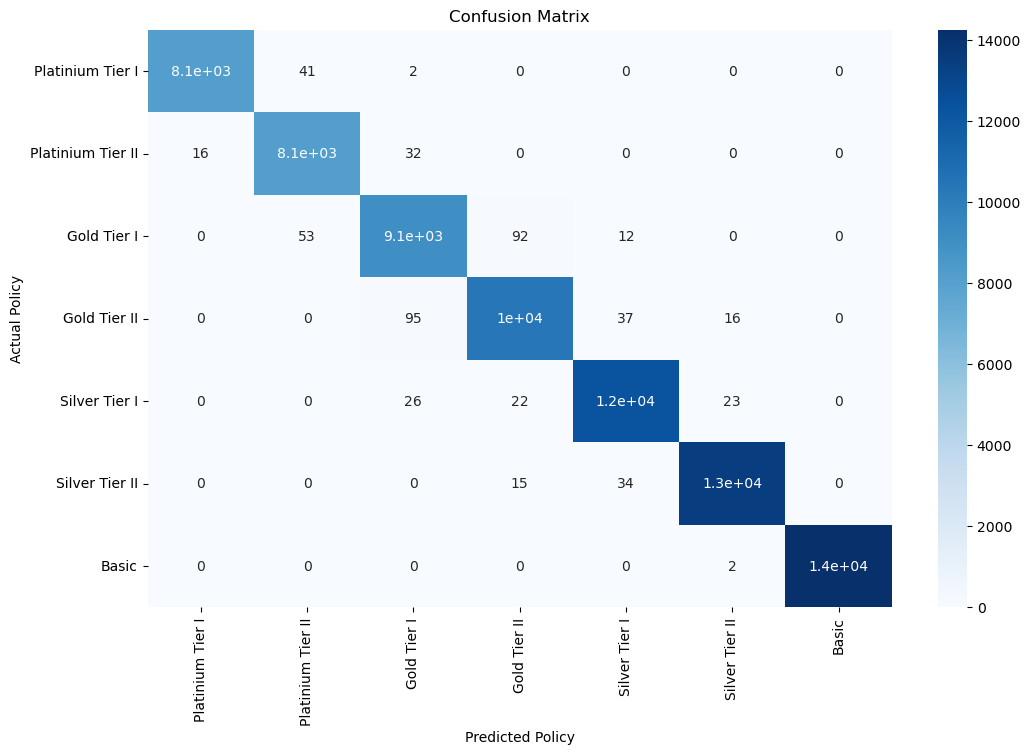

In [289]:
# Create a heatmap directly from the DataFrame
with plt.rc_context({"figure.figsize":(12,7.5)}):
    sns.heatmap(confusionMatrix_lgb, cmap='Blues', annot=True)  # Adjust colormap as desired
    
    # Customize the plot 
    plt.xlabel('Predicted Policy')
    plt.ylabel('Actual Policy')
    plt.title('Confusion Matrix')
    plt.show()

In [290]:
# Get the classification report
y_pred_lgb_decoded = y_encoder.inverse_transform(y_pred_lgb.reshape(-1,1))
y_test_lgb_decoded = y_encoder.inverse_transform(np.array(y_test_bgm).reshape(-1,1))
report_lgb = classification_report(y_test_lgb_decoded, y_pred_lgb_decoded,output_dict=True)
# Print the classification report (includes decision matrix)
print("Classification Report:")
pretty_display(DataFrame(report_lgb).transpose(),format = "{:.5f}")

Classification Report:


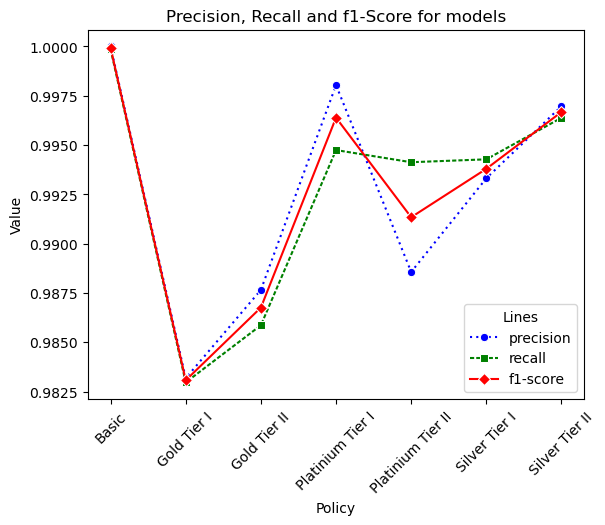

In [291]:
# Create the plot using sns.lineplot
report_lgb_df = DataFrame(report_lgb).transpose().drop("support",axis=1).drop(["accuracy",'macro avg','weighted avg'],axis=0).reset_index()
report_lgb_df = report_lgb_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], 
                  var_name='variable', value_name='value')

# Create lineplot with
sns.lineplot(data = report_lgb_df, 
             x = 'index', 
             y = 'value',
             hue='variable', 
             style='variable', 
             markers = ['o','s','D'],
             dashes = [(1,2),(2,1),''],
             palette = ["blue","green","red"])
            

# Customize the plot
plt.title("Precision, Recall and f1-Score for models")
plt.xlabel("Policy")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend(title="Lines")
plt.show()

In [292]:
# Calculate various classification metrics
accuracy_lgb = accuracy_score(y_test_bgm, y_pred_lgb)
precision = precision_score(y_test_bgm, y_pred_lgb, average = 'weighted')
recall = recall_score(y_test_bgm, y_pred_lgb, average = 'weighted')
f1 = f1_score(y_test_bgm, y_pred_lgb, average = 'weighted')


metrics = DataFrame({"Metric":["Accuracy", "Precision", "Recall", "f1"],
                     "Measure":[accuracy_lgb, precision, recall, f1]})

pretty_display(metrics, format = "{:.5f}")
del(metrics,precision,recall,f1)

<h3>Logistic Regression</h3>

In [293]:
# Initializing Model
logr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)
logr = logr.fit(X_train, y_train)

In [294]:
y_pred_logr = logr.predict(X_test)
accuracy_logr = accuracy_score(y_test, y_pred_logr)
print(accuracy_logr)

0.7728870929652856


<p> Since Logistic Regression is not able to provide high accuracy we abandon this model.</p>

<h3> Gaussian Naive Bayes </h3>

In [295]:
gnb = GaussianNB()
gnb_fit = gnb.fit(X_train,y_train)

In [296]:
y_pred_gnb = gnb_fit.predict(X_test)

In [300]:
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print("Accuracy with all features:", accuracy_gnb)

Accuracy with all features: 0.6993650127259846


In [298]:
gnb_fit2 = gnb.fit(X_train[["Annual_Income","Age"]],y_train)
y_pred_gnb2 = gnb_fit2.predict(X_test[["Annual_Income","Age"]])
accuracy2 = accuracy_score(y_test, y_pred_gnb2)
print("Accuracy with continious features:", accuracy2)

Accuracy with continious features: 0.6856812993623889


In [299]:
gnb_fit3 = gnb.fit(X_train.drop(["Annual_Income","Age"],axis=1),y_train)
y_pred_gnb3 = gnb_fit3.predict(X_test.drop(["Annual_Income","Age"],axis=1))
accuracy3 = accuracy_score(y_test, y_pred_gnb3)
print("Accuracy with categorical features:", accuracy3)

Accuracy with categorical features: 0.42347353782372543


<p> Since Gaussian Naive Bayes is not able to provide high accuracy we abandon this model. Since Gaussian Naive Bayes required continious data but most of our fields are categorical, the model is not able to give a good performance. If we only test with the two continious variables that we have we get a similiar accuracy and only with categorical features we get a significant low accuracy, thus proving our hypothesis. Hence we try categorical Naive Bayes.</p>

<h3> Categorical Naive Bayes</h3>

In [301]:
categorical_columns = df_bgm.select_dtypes(include=['category']).columns
X_train_bgm[categorical_columns] = X_train_bgm[categorical_columns].apply(lambda x: x.cat.codes)
X_val_bgm[categorical_columns] = X_val_bgm[categorical_columns].apply(lambda x: x.cat.codes)
X_test_bgm[categorical_columns] = X_test_bgm[categorical_columns].apply(lambda x: x.cat.codes)
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', KBinsDiscretizer(n_bins=500, encode='ordinal', strategy='uniform'), ["Age","Annual_Income"]),
    ]
)

In [302]:
# Define the Categorical Naive Bayes pipeline
categorical_nb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CategoricalNB(alpha = 1))
])

In [303]:
cnb = categorical_nb_pipeline.fit(X_train_bgm,y_train_bgm)

In [304]:
y_pred_cnb = cnb.predict(X_test_bgm)

In [305]:
accuracy_cnb = accuracy_score(y_test_bgm, y_pred_cnb)

In [306]:
print(accuracy_cnb)

0.7567369001075804


<p> Since Categorical Naive Bayes is not able to provide high accuracy we abandon this model. This may be because the most important parameter Annual Income is a continious feature and has been converted to categorical feature. But its accuracy is better than Gaussian Naive Bayes. Naive Bayes assumes that features are conditionally independent given the class label. This assumption is rarely true in real-world data, leading to suboptimal performance when there are dependencies among features. Tree-based models do not rely on this assumption and can capture complex interactions between features. Also CNB assumes categorical data and a multinomial distribution of features. If your data does not fit these assumptions well, CNB may perform poorly compared to tree-based models, which are non-parametric and can handle a wider range of data distributions. </p>

<h3>Kernel SVM</h3>

In [307]:
svm = SVC(kernel='rbf', gamma='scale', decision_function_shape='ovr')

In [308]:
if exists ('svm_model.joblib'):
    print("Loading from file")
    svm_loaded = joblib.load('svm_model.joblib')
    y_pred_svm = svm_loaded.predict(X_test)
else:
    svm = svm.fit(X_train,y_train_float)
    # Save the model to a file
    joblib.dump(svm, 'svm_model.joblib')
    y_pred_svm = svm.predict(X_test)

Loading from file


<h4> Model Evaluation </h4>

In [309]:
accuracy_svm = accuracy_score(y_test_float, y_pred_svm)

In [310]:
print(accuracy_svm)

0.8599748104221878


In [311]:
# Confusion Matrix

policy_order = ["Platinium Tier I", "Platinium Tier II", "Gold Tier I", "Gold Tier II", "Silver Tier I", "Silver Tier II", "Basic"]
confusionMatrix_svm = DataFrame(confusion_matrix(y_test_float, y_pred_svm), columns = policy_order, index = policy_order)
confusionMatrix_svm = confusionMatrix_lgb.loc[policy_order,policy_order]
pretty_display(confusionMatrix_svm)
del(policy_order)

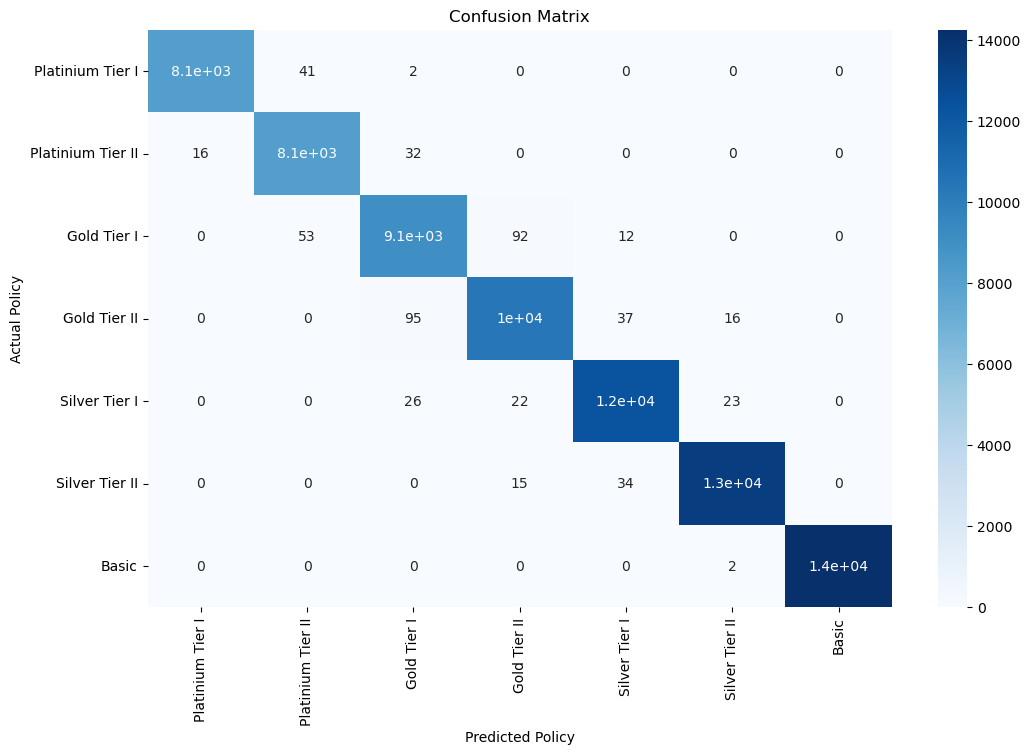

In [312]:
# Create a heatmap directly from the DataFrame
with plt.rc_context({"figure.figsize":(12,7.5)}):
    sns.heatmap(confusionMatrix_svm, cmap='Blues', annot=True)  # Adjust colormap as desired
    
    # Customize the plot 
    plt.xlabel('Predicted Policy')
    plt.ylabel('Actual Policy')
    plt.title('Confusion Matrix')
    plt.show()

In [313]:
# Get the classification report
y_pred_svm_decoded = y_encoder.inverse_transform(y_pred_svm.reshape(-1,1))
report_svm = classification_report(y_test, y_pred_svm_decoded,output_dict=True)
# Print the classification report (includes decision matrix)
print("Classification Report:")
pretty_display(DataFrame(report_svm).transpose(),format = "{:.5f}")

Classification Report:


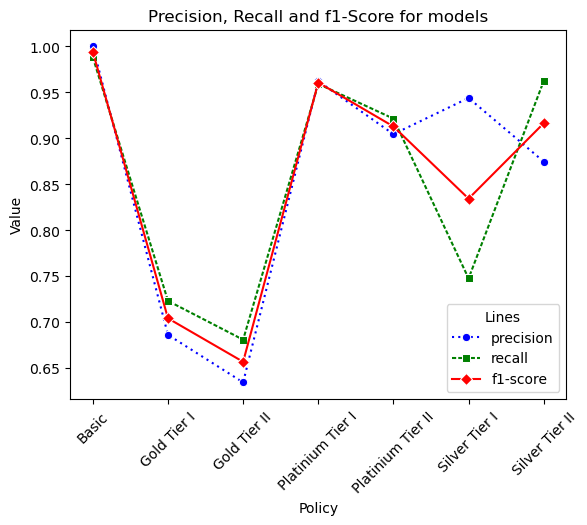

In [314]:
# Create the plot using sns.lineplot
report_svm_df = DataFrame(report_svm).transpose().drop("support",axis=1).drop(["accuracy",'macro avg','weighted avg'],axis=0).reset_index()
report_svm_df = report_svm_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], 
                  var_name='variable', value_name='value')

# Create lineplot with
sns.lineplot(data = report_svm_df, 
             x = 'index', 
             y = 'value',
             hue='variable', 
             style='variable', 
             markers = ['o','s','D'],
             dashes = [(1,2),(2,1),''],
             palette = ["blue","green","red"])
            

# Customize the plot
plt.title("Precision, Recall and f1-Score for models")
plt.xlabel("Policy")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend(title="Lines")
plt.show()

In [315]:
# Calculate various classification metrics
accuracy = accuracy_score(y_test_float, y_pred_svm)
precision = precision_score(y_test_float, y_pred_svm, average = 'weighted')
recall = recall_score(y_test_float, y_pred_svm, average = 'weighted')
f1 = f1_score(y_test_float, y_pred_svm, average = 'weighted')


metrics = DataFrame({"Metric":["Accuracy", "Precision", "Recall", "f1"],
                     "Measure":[accuracy, precision, recall, f1]})

pretty_display(metrics, format = "{:.5f}")
del(metrics,accuracy,precision,recall,f1)

<p> SVM is giving a pretty high accuracy of 86%, but not as high as other models. Also the classification performance is especially poor for Gold Tier  I and II and Silver Tier I so we will abandon this model.</p>

<h3> Deep Learning - Multilayer Perceptron </h3>

<h4>Setting up the nueral network</h4>

In [215]:
mlp = Sequential()
mlp.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(7, activation='softmax'))  # 7 classes for the output layer

In [216]:
# Compile the model
mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
y_train_encoded = to_categorical(y_train_float, num_classes=7)
y_test_encoded = to_categorical(y_test_float, num_classes=7)
y_val_encoded = to_categorical(y_val_float, num_classes=7)

In [338]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = mlp.fit(X_train, y_train_encoded, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
17786/17786 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9867 - loss: 0.0337 - val_accuracy: 0.9834 - val_loss: 0.0429
Epoch 2/100
17786/17786 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9866 - loss: 0.0334 - val_accuracy: 0.9835 - val_loss: 0.0467
Epoch 3/100
17786/17786 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9868 - loss: 0.0336 - val_accuracy: 0.9857 - val_loss: 0.0381
Epoch 4/100
17786/17786 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9868 - loss: 0.0335 - val_accuracy: 0.9868 - val_loss: 0.0350
Epoch 5/100
17786/17786 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9866 - loss: 0.0337 - val_accuracy: 0.9825 - val_loss: 0.0490
Epoch 6/100
17786/17786 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.9868 - loss: 0.0337 - val_accuracy: 0.9857 - val_loss: 0.0382
Epoch 7/100
17786/17786 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9870 - loss: 0.0329 - val_accuracy: 0.9888 - val_loss: 0.0298
Epoch 8/100
17786/17786 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - ac

<h4> Model Evaluation </h4>

In [339]:
loss, accuracy = mlp.evaluate(X_test,y_test_encoded)
print(f"Loss:{loss}, Accuracy:{accuracy}")

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9885 - loss: 0.0305
Loss:0.02909122221171856, Accuracy:0.9890451431274414


In [340]:
mlp.save('mlp_model.keras')

In [341]:
loaded_model = load_model('mlp_model.keras')

In [342]:
y_pred_mlp = loaded_model.predict(X_test)

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step


In [343]:
y_pred_mlp_classes = np.argmax(y_pred_mlp, axis=1)

In [344]:
# Confusion Matrix

policy_order = ["Platinium Tier I", "Platinium Tier II", "Gold Tier I", "Gold Tier II", "Silver Tier I", "Silver Tier II", "Basic"]
confusionMatrix_mlp = DataFrame(confusion_matrix(y_test_float, y_pred_mlp_classes), columns = policy_order, index = policy_order)
confusionMatrix_mlp = confusionMatrix_mlp.loc[policy_order,policy_order]
pretty_display(confusionMatrix_mlp)
del(policy_order)

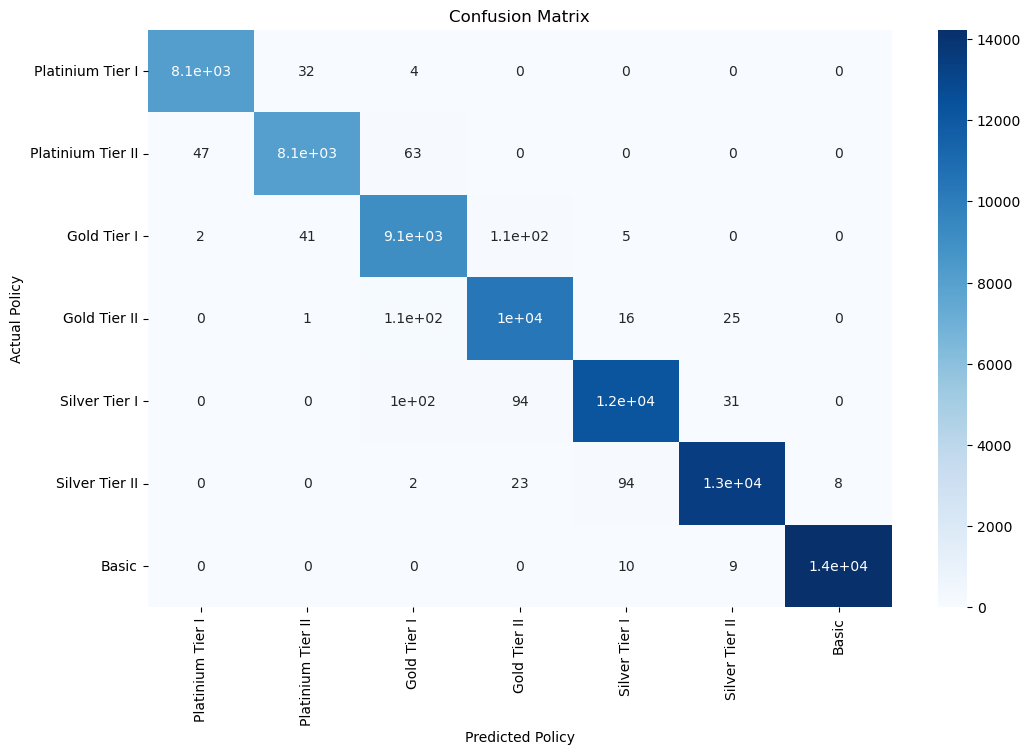

In [345]:
# Create a heatmap directly from the DataFrame
with plt.rc_context({"figure.figsize":(12,7.5)}):
    sns.heatmap(confusionMatrix_mlp, cmap='Blues', annot=True)  # Adjust colormap as desired
    
    # Customize the plot 
    plt.xlabel('Predicted Policy')
    plt.ylabel('Actual Policy')
    plt.title('Confusion Matrix')
    plt.show()

In [346]:
# Get the classification report
y_pred_mlp_decoded = y_encoder.inverse_transform(y_pred_mlp_classes.reshape(-1,1))
report_mlp = classification_report(y_test, y_pred_mlp_decoded,output_dict=True)
# Print the classification report (includes decision matrix)
print("Classification Report:")
pretty_display(DataFrame(report_mlp).transpose(),format = "{:.5f}")

Classification Report:


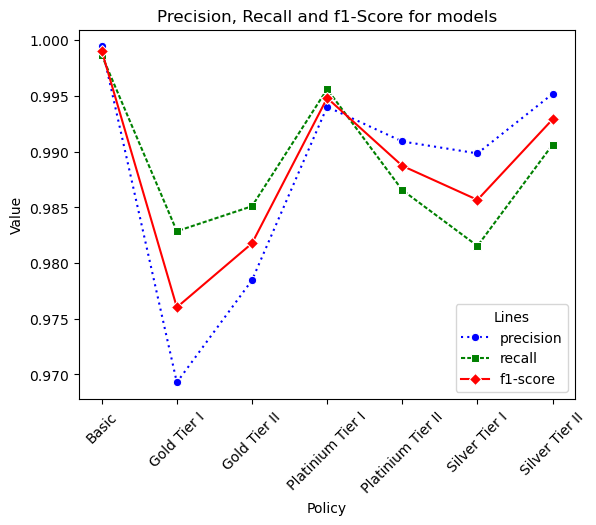

In [347]:
# Create the plot using sns.lineplot
report_mlp_df = DataFrame(report_mlp).transpose().drop("support",axis=1).drop(["accuracy",'macro avg','weighted avg'],axis=0).reset_index()
report_mlp_df = report_mlp_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], 
                  var_name='variable', value_name='value')

# Create lineplot with
sns.lineplot(data = report_mlp_df, 
             x = 'index', 
             y = 'value',
             hue='variable', 
             style='variable', 
             markers = ['o','s','D'],
             dashes = [(1,2),(2,1),''],
             palette = ["blue","green","red"])
            

# Customize the plot
plt.title("Precision, Recall and f1-Score for models")
plt.xlabel("Policy")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend(title="Lines")
plt.show()

In [348]:
# Calculate various classification metrics
accuracy_mlp = accuracy_score(y_test_float, y_pred_mlp_classes)
precision = precision_score(y_test_float, y_pred_mlp_classes, average = 'weighted')
recall = recall_score(y_test_float, y_pred_mlp_classes, average = 'weighted')
f1 = f1_score(y_test_float, y_pred_mlp_classes, average = 'weighted')


metrics = DataFrame({"Metric":["Accuracy", "Precision", "Recall", "f1"],
                     "Measure":[accuracy_mlp, precision, recall, f1]})

pretty_display(metrics, format = "{:.5f}")
del(metrics,precision,recall,f1)

<h2> Conclusion: Comparision of Models </h2>

In [349]:
model_dict = {
    "model": ['Decision Trees', 'Random Forest', 'AdaBoost', 'XGBoost', 'LightBGM', 'Logistic Regression', 
              'Gaussian Naive Bayes', 'Categorical Naive Bayes', 'RGBF Kernel SVM', 'Multi-Layer Perceptron'],
    "accuracy": [accuracy_dt, accuracy_rf, accuracy_ada, accuracy_xgb, accuracy_lgb, accuracy_logr,
                 accuracy_gnb, accuracy_cnb, accuracy_svm, accuracy_mlp]
}

model_df = DataFrame(model_dict)

pretty_display(model_df, format="{:.5f}")

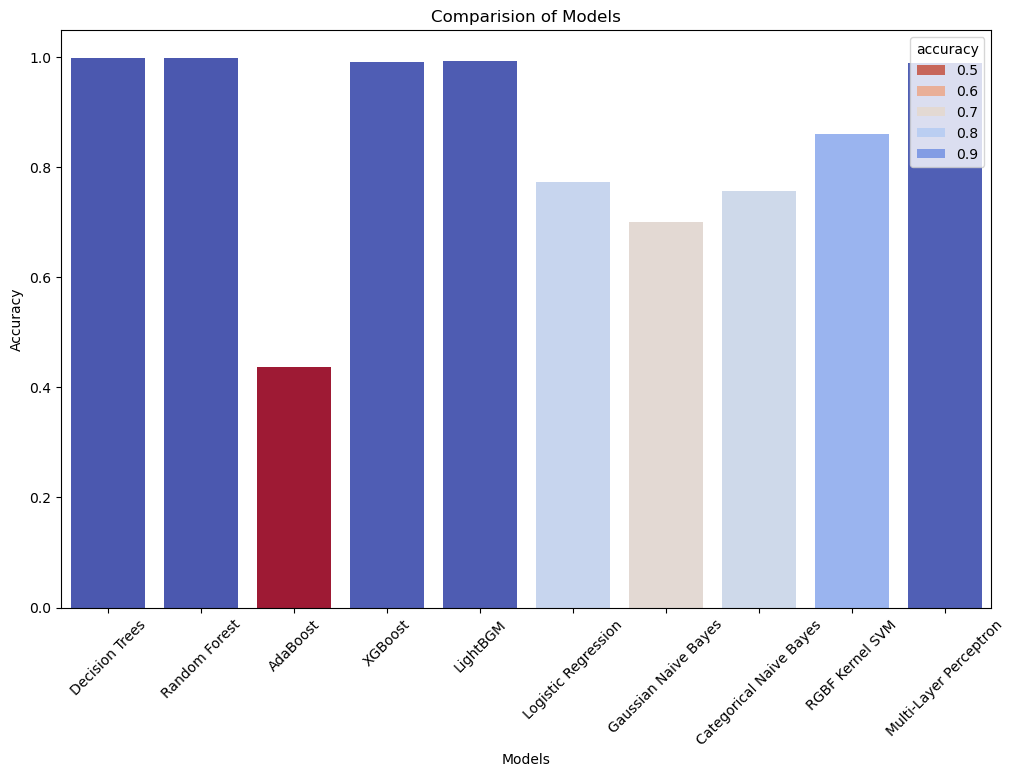

In [350]:
with plt.rc_context({"figure.figsize":(12,7.5)}):
    sns.barplot(data = model_df,
                x = "model",
                y = "accuracy", 
                hue = "accuracy",
                palette = "coolwarm_r")

plt.title("Comparision of Models")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

<p> The tree-based models such as decision trees, random forest, XGBoost, LightBGM (although AdaBoost performed the worst) performed the best along with the Deep Learning model Multi-Layer Perceptron. The next best-performing model in the accuracy range of 85% was RGBF Kernel SVM. Logistic Regression, Categorical and Gaussian Naive Bayes were ranked in terms of accuracy after kernel SVM with accuracy in the 70-80% range.